# **Supervised Learning - Foundations Project: ReCell**

- Student: Alexey Tyurin
- Group: Oct'22 C Sun - MLS Grp B
- Batch: PGP-DSBA-UTA-OCT22-C
- Date: 2/23/2024

# Problem Statement

## Business Context

Buying and selling used phones and tablets used to be something that happened on a handful of online marketplace sites. But the used and refurbished device market has grown considerably over the past decade, and a new IDC (International Data Corporation) forecast predicts that the used phone market would be worth \$52.7bn by 2023 with a compound annual growth rate (CAGR) of 13.6% from 2018 to 2023. This growth can be attributed to an uptick in demand for used phones and tablets that offer considerable savings compared with new models.

Refurbished and used devices continue to provide cost-effective alternatives to both consumers and businesses that are looking to save money when purchasing one. There are plenty of other benefits associated with the used device market. Used and refurbished devices can be sold with warranties and can also be insured with proof of purchase. Third-party vendors/platforms, such as Verizon, Amazon, etc., provide attractive offers to customers for refurbished devices. Maximizing the longevity of devices through second-hand trade also reduces their environmental impact and helps in recycling and reducing waste. The impact of the COVID-19 outbreak may further boost this segment as consumers cut back on discretionary spending and buy phones and tablets only for immediate needs.

## Objective

The rising potential of this comparatively under-the-radar market fuels the need for an ML-based solution to develop a dynamic pricing strategy for used and refurbished devices. ReCell, a startup aiming to tap the potential in this market, has hired you as a data scientist. They want you to analyze the data provided and build a linear regression model to predict the price of a used phone/tablet and identify factors that significantly influence it.

## Data Description

The data contains the different attributes of used/refurbished phones and tablets. The data was collected in the year 2021. The detailed data dictionary is given below.


- brand_name: Name of manufacturing brand
- os: OS on which the device runs
- screen_size: Size of the screen in cm
- 4g: Whether 4G is available or not
- 5g: Whether 5G is available or not
- main_camera_mp: Resolution of the rear camera in megapixels
- selfie_camera_mp: Resolution of the front camera in megapixels
- int_memory: Amount of internal memory (ROM) in GB
- ram: Amount of RAM in GB
- battery: Energy capacity of the device battery in mAh
- weight: Weight of the device in grams
- release_year: Year when the device model was released
- days_used: Number of days the used/refurbished device has been used
- normalized_new_price: Normalized price of a new device of the same model in euros
- normalized_used_price: Normalized price of the used/refurbished device in euros

# Importing necessary libraries

In [1]:
#!pip install nb_black

In [2]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# basic libraries for reading, manipulating data and scientific computing
import numpy as np
import pandas as pd

# data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

# split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# cross-sectional models and methods
# OLS - to build linear regression model with ordinary least squares
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# statistical functions
import scipy.stats as st

# metrics and scoring
# quantifying the quality of predictions to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

# Loading the dataset

In [3]:
# Loding the dataset
df = pd.read_csv('used_device_data.csv')

<IPython.core.display.Javascript object>

# User-defined functions

## Functions to carry out the EDA

### Combined boxplot and histogram

In [4]:
# functiom to create combined boxplot and histogram
def histogram_boxplot(data, feature, figsize=(10, 5), fmt='{:.1f}',
                      title=None, kde=True, bins=None, step=None, xlabel=None):
    x = data[feature]
    colors = sns.color_palette("Spectral")
    title = title if title else f'Distribution for `{feature}` column'

    x_min, x_max = x.min(), x.max()

    if (bins == None) & (step == None):
        bins = int(3 * np.log(x.nunique())) + 2
    elif bins == None:
        x_min = step * round(x_min / step, 0)
        x_max = step * round(x_max / step, 0) + step
        bins = int((x_max - x_min) / step)

    bw = (x_max - x_min) / bins

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize,
                           gridspec_kw={"height_ratios": (0.3, 0.7)})

    plt.suptitle(title, fontsize=16)
    box = sns.boxplot(data=data, x=feature, ax=ax[0], showmeans=True, color=colors[1])
    hist = sns.histplot(data=data, x=feature, kde=kde, ax=ax[1], color=colors[4], bins=bins)

    ax[0].set_xlabel('')
    ax[1].axvline(x.median(), color="grey", linestyle="-")
    ax[1].axvline(x.mean(), color="darkgreen", linestyle="--")
    ax[1].set_ylabel('Number of devices', fontsize=12)
    if xlabel: ax[1].set_xlabel(xlabel, fontsize=12)

    labels = [fmt.format(x) for x in np.arange(x_min, x_max, bw)]
    ticks =  [x+bw/2 for x in np.arange(x_min, x_max, bw)]

    ax[1].set_xticks(ticks)
    ax[1].set_xticklabels(labels)

    plt.show();

<IPython.core.display.Javascript object>

### Labeled barplots

In [5]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None, percfmt="{:.1f}%", rnd=0,
                    figsize=(10, 5), xlabel=None, xlo=0, title=None, sort=True, 
                    orient='h'):
    """
    Barplot with percentage at the top

    data: dataframe
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    figsize: size of figure (default (10, 5))
    xlabel: label for x axis
    """

    fig, ax = plt.subplots(figsize=figsize)
    plt.xticks(rotation=xlo, fontsize=14)
    if orient == 'h':
      sns.countplot(data=data, x=feature, palette="Paired",
                    order=data[feature].value_counts().index[:n] if sort else None)
    else:
      sns.countplot(data=data, y=feature, palette="Paired",
                    order=data[feature].value_counts().index[:n] if sort else None)

    # draw lables
    for p in ax.patches:
      if orient == 'h':
        if perc == True: label = percfmt.format(100 * p.get_height() / data.shape[0])
        else: label = p.get_height()
        ax.annotate(label, (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha="center", va="center", size=11, xytext=(0, 5),
                    textcoords="offset points")
        ax.set_ylabel('Number of devices', fontsize=14)
        if xlabel: ax.set_xlabel(xlabel, fontsize=14)
      else:
        if perc == True:
          label = percfmt.format(100 * p.get_width() / data.shape[0])
        else:
          label = p.get_height()
        ax.annotate(label, (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha="center", va="center", size=11, xytext=(15, 0),
                    textcoords="offset points")
        ax.set_xlabel('Number of devices', fontsize=14)
        if xlabel: ax.set_ylabel(xlabel, fontsize=14)

    if title: plt.title(title, fontsize=16)
    else: plt.title(f'Distribution for `{feature}` column', fontsize=16)

    plt.show()

<IPython.core.display.Javascript object>

## Functions for model check

### Function to compute different metrics to check performance of a regression model

In [6]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

### Function for Variance Inflation Factor

In [7]:
def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    # calculating VIF for each feature
    vif["VIF"] = [variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]
    return vif

<IPython.core.display.Javascript object>

### Function for Treating Multicollinearity

In [8]:
def treating_multicollinearity(predictors, target, high_vif_columns):
    """
    Checking the effect of dropping the columns showing high multicollinearity
    on model performance (adj. R-squared and RMSE)

    predictors: independent variables
    target: dependent variable
    high_vif_columns: columns having high VIF
    """
    # empty lists to store adj. R-squared and RMSE values
    r2 = []
    adj_r2 = []
    rmse = []

    # build ols models by dropping one of the high VIF columns at a time
    # store the adjusted R-squared and RMSE in the lists defined previously
    for cols in high_vif_columns:
        # defining the new train set
        train = predictors.loc[:, ~predictors.columns.str.startswith(cols)]

        # create the model
        olsmodel = sm.OLS(target, train).fit()

        # adding adj. R-squared and RMSE to the lists
        r2.append(olsmodel.rsquared)
        adj_r2.append(olsmodel.rsquared_adj)
        rmse.append(np.sqrt(olsmodel.mse_resid))

    # creating a dataframe for the results
    temp = pd.DataFrame(
        {
            "col": high_vif_columns,
            "R-squared": r2,
            "Adj. R-squared after_dropping col": adj_r2,
            "RMSE after dropping col": rmse,
        }
    ).sort_values(by="Adj. R-squared after_dropping col", ascending=False)
    temp.reset_index(drop=True, inplace=True)

    return temp

<IPython.core.display.Javascript object>

# Data Overview

The initial steps to get an overview of any dataset is to:

- [x] Observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- [x] Get information about the number of rows and columns in the dataset
- [x] Find out the data types of the columns 
- [x] Ensure that data is stored in the preferred format and the value of each property is as expected
- [x] Check the statistical summary of the dataset to get an overview of the numerical columns of the data.
- [x] Sanity checks.
- [x] Observations.

## Displaying few first and last rows of the dataset

In [9]:
# view the first five rows of the dataset
df.head()

brand_name       os  screen_size   4g   5g  main_camera_mp  \
0      Honor  Android        14.50  yes   no            13.0   
1      Honor  Android        17.30  yes  yes            13.0   
2      Honor  Android        16.69  yes  yes            13.0   
3      Honor  Android        25.50  yes  yes            13.0   
4      Honor  Android        15.32  yes   no            13.0   

   selfie_camera_mp  int_memory  ram  battery  weight  release_year  \
0               5.0        64.0  3.0   3020.0   146.0          2020   
1              16.0       128.0  8.0   4300.0   213.0          2020   
2               8.0       128.0  8.0   4200.0   213.0          2020   
3               8.0        64.0  6.0   7250.0   480.0          2020   
4               8.0        64.0  3.0   5000.0   185.0          2020   

   days_used  normalized_used_price  normalized_new_price  
0        127               4.307572              4.715100  
1        325               5.162097              5.519018  
2        162               5.111084              5.884631  
3        345               5.135387              5.630961  
4        293               4.389995              4.947837

<IPython.core.display.Javascript object>

In [10]:
# view the last five rows of the dataset
df.tail()

brand_name       os  screen_size   4g  5g  main_camera_mp  \
3449       Asus  Android        15.34  yes  no             NaN   
3450       Asus  Android        15.24  yes  no            13.0   
3451    Alcatel  Android        15.80  yes  no            13.0   
3452    Alcatel  Android        15.80  yes  no            13.0   
3453    Alcatel  Android        12.83  yes  no            13.0   

      selfie_camera_mp  int_memory  ram  battery  weight  release_year  \
3449               8.0        64.0  6.0   5000.0   190.0          2019   
3450               8.0       128.0  8.0   4000.0   200.0          2018   
3451               5.0        32.0  3.0   4000.0   165.0          2020   
3452               5.0        32.0  2.0   4000.0   160.0          2020   
3453               5.0        16.0  2.0   4000.0   168.0          2020   

      days_used  normalized_used_price  normalized_new_price  
3449        232               4.492337              6.483872  
3450        541               5.037732              6.251538  
3451        201               4.357350              4.528829  
3452        149               4.349762              4.624188  
3453        176               4.132122              4.279994

<IPython.core.display.Javascript object>

* The dataset contains information about different attributes of used/refurbished phones and tablets
* Many devices seem to have 4g, but not all of them support 5g
* Column `main_camera_mp` seems to be missing for some phones

## Get information about the number of rows and columns in the dataset


In [11]:
# view the shape of the dataset
df.shape

(3454, 15)

<IPython.core.display.Javascript object>

* The dataset contains 3454 rows and 15 columns - 15 attributes/factors of 3454 devices

## Checking the data types of the columns for the dataset

In [12]:
# view concise summary of the dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand_name             3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   main_camera_mp         3275 non-null   float64
 6   selfie_camera_mp       3452 non-null   float64
 7   int_memory             3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

<IPython.core.display.Javascript object>

* There are 11 numeric (*float* and *int* types) and 4 string (*object* type) columns in the dataset
* Some columns have missing (`NA`) values: `main_camera_mp`, `selfie_camera_mp`, `int_memory`, `ram`, `battery`, `weight`
* The target variable is the `normalized_used_price` which is of *float* type

## Statistical summary of the dataset

In [13]:
df.describe(include=np.number).T

count         mean          std          min  \
screen_size            3454.0    13.713115     3.805280     5.080000   
main_camera_mp         3275.0     9.460208     4.815461     0.080000   
selfie_camera_mp       3452.0     6.554229     6.970372     0.000000   
int_memory             3450.0    54.573099    84.972371     0.010000   
ram                    3450.0     4.036122     1.365105     0.020000   
battery                3448.0  3133.402697  1299.682844   500.000000   
weight                 3447.0   182.751871    88.413228    69.000000   
release_year           3454.0  2015.965258     2.298455  2013.000000   
days_used              3454.0   674.869716   248.580166    91.000000   
normalized_used_price  3454.0     4.364712     0.588914     1.536867   
normalized_new_price   3454.0     5.233107     0.683637     2.901422   

                               25%          50%          75%          max  
screen_size              12.700000    12.830000    15.340000    30.710000  
main_camera_mp            5.000000     8.000000    13.000000    48.000000  
selfie_camera_mp          2.000000     5.000000     8.000000    32.000000  
int_memory               16.000000    32.000000    64.000000  1024.000000  
ram                       4.000000     4.000000     4.000000    12.000000  
battery                2100.000000  3000.000000  4000.000000  9720.000000  
weight                  142.000000   160.000000   185.000000   855.000000  
release_year           2014.000000  2015.500000  2018.000000  2020.000000  
days_used               533.500000   690.500000   868.750000  1094.000000  
normalized_used_price     4.033931     4.405133     4.755700     6.619433  
normalized_new_price      4.790342     5.245892     5.673718     7.847841

<IPython.core.display.Javascript object>

In [14]:
df.describe(include='object').T.fillna('')

count  unique      top  freq
brand_name   3454      34   Others   502
os           3454       4  Android  3214
4g           3454       2      yes  2335
5g           3454       2       no  3302

<IPython.core.display.Javascript object>

In [15]:
# Mode
df.mode().loc[0,:]

brand_name                 Others
os                        Android
screen_size                  12.7
4g                            yes
5g                             no
main_camera_mp               13.0
selfie_camera_mp              5.0
int_memory                   16.0
ram                           4.0
battery                    4000.0
weight                      150.0
release_year               2014.0
days_used                   564.0
normalized_used_price    3.535145
normalized_new_price      5.13574
Name: 0, dtype: object

<IPython.core.display.Javascript object>

In [16]:
# `selfie_camera_mp` mean value (exclusding value 0)
df.selfie_camera_mp.apply(lambda x: x if x>0 else None).mean()

6.629123937884558

<IPython.core.display.Javascript object>

## Sanity checks

In [17]:
# Sanity model is a model where all target values ​​are constant and equal to the average of the target column. 
# Let's estimate the value of the MAE and RMSE metrics of the sanity model.
# We will consider a model valuable if its MAE and RMSE are less than values of the sanity check model.

y_train, y_test = train_test_split(df['normalized_used_price'], test_size=0.3, random_state=42)

train_price_mean = y_train.mean()
MAE_sanity = mean_absolute_error(y_test, [train_price_mean] * len(y_test))
RMSE_sanity = mean_squared_error(y_test, [train_price_mean] * len(y_test))**0.5
print(f'Sanity MAE for the mean value is {MAE_sanity:.2f}')
print(f'Sanity RMSE for the mean value is {RMSE_sanity:.2f}')

Sanity MAE for the mean value is 0.44
Sanity RMSE for the mean value is 0.58


<IPython.core.display.Javascript object>

## Checking for duplicate values

In [18]:
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

* There are no duplicate values in the dataset

## Checking for missing values

In [19]:
df.isnull().sum()

brand_name                 0
os                         0
screen_size                0
4g                         0
5g                         0
main_camera_mp           179
selfie_camera_mp           2
int_memory                 4
ram                        4
battery                    6
weight                     7
release_year               0
days_used                  0
normalized_used_price      0
normalized_new_price       0
dtype: int64

<IPython.core.display.Javascript object>

* There are missing values in many columns.

## **Observations:**

* We can see that the used device normzlized prices vary between 1.54 and 6.62
  * The mean price is 4.36 normalized euros
* There are 34 brands in the dataset, most of the devices fell into the category of "Others"
* All devices are divided into 4 groups by operating systems. 93% of the devices operate on Android
* Screen size vary between 5.08cm	and 30.71cm
  * The mean size is 13.71cm
  * The most frequent size is 12.7cm
* 4G/5G availability
  * 68% of the devices support 4G
  * 4% support 5G
* Resolution of the rear camera vary from 0.3MP to 48MP (one device has 80 kilo-pixels main camera)
  * The average is 9.46MP (13MP appears most frequently in the dataset)
  * There are 179 missing values in this column
* Resolution of the front camera vary from 0.3MP to 32MP
  * The average is 6.55MP (5MP appears most frequently in the dataset)
  * The mean exclusing 0 is 6.6MP
  * There are 2 missing values in this column, but many rows contain 0 value in this column
* Amount of ROM (`int_memory`) is between 8Mb and 1Tb
  * The mean of ROM is 54.6GB, median is 32GB (skewed right), mode is 16GB
  * 4 missing values in this column
* Amount of RAM is between 16Mb and 12Gb
  * The mean, median and mode of RAM are 4GB
  * 4 missing values in this column
* Energy capacity of the device battery varies between 500mAh and 9720mAh
  * The mean is 3133mAh (4000mAh appears most frequently)
  * 6 missing values in this column
* Device weight varies from 69g to 855g, average weight is 183g, median is 160g, mode is 150g
  * 7 missing values in this column
* The device model year is represented by 8 years in the dataset, from 2013 to 2020
  * Most of the devices in the dataset were released in 2014
* The terms of used/refurbished devices usage vary from 3 months to 3 years
  * The mean is 1 year and 10 months approximately
  * The median is 1 year and 11 months approximately
  * The term of 564 days (1 year 7 months) appears most frequently
* The normalized price of a new device of the same model vary between 2.90 and 7.85
  * The mean of normalized price of a new device of the same model is 5.23 normalized euros. 
* The price of a used device is on average 83.4% of a new device price of the same model
  * In other words, a new device is 20% more expensive than the same model of used device.
* Sanity checks
  * To be better than simple average, the MAE of the model need to be less than 0.44, RMSE - less than 0.58
* There are no duplicate values in the dataset.
* There are missing values in many columns.

# Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below to help us approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data has been done, in addition to the questions mentioned below.

## Univariate analysis

### Continuous variables

**`normalized_used_price`**

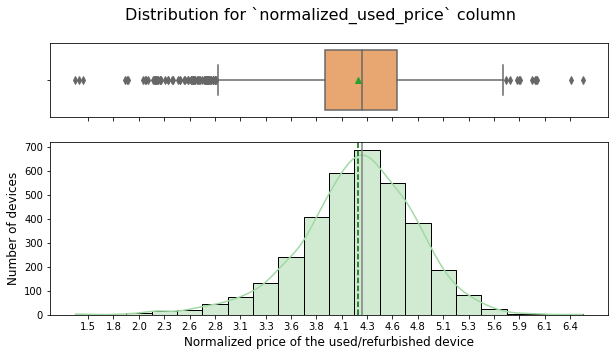

<IPython.core.display.Javascript object>

In [20]:
histogram_boxplot(data=df, feature='normalized_used_price', fmt='{:.1f}', bins=20,
                  xlabel='Normalized price of the used/refurbished device')


* The normalized used device prices look symmetric (bell shaped), unimodal, close to normally distributed
* Normalized used device price is approximately 4.4 on average 
* The range is 1.5-6.6
* There are many outliers below and above the overall pattern in a distribution

**`normalized_new_price`**

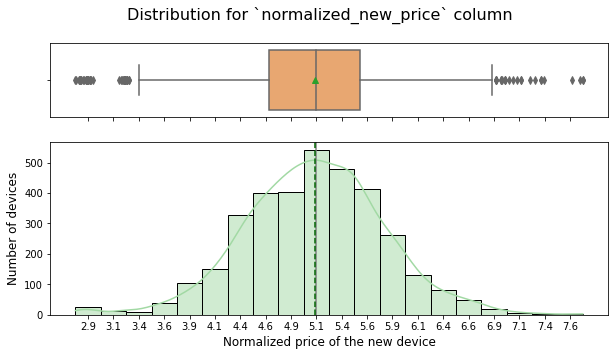

<IPython.core.display.Javascript object>

In [21]:
histogram_boxplot(data=df, feature='normalized_new_price', fmt='{:.1f}', bins=20,
                  xlabel='Normalized price of the new device')

* The normalized new device prices look symmetric (bell shaped), unimodal, close to normally distributed
* Normalized used device price is approximately 5.2 on average 
* The range is 2.9-7.8
* There are many outliers below and above the overall pattern in a distribution

**`battery`**

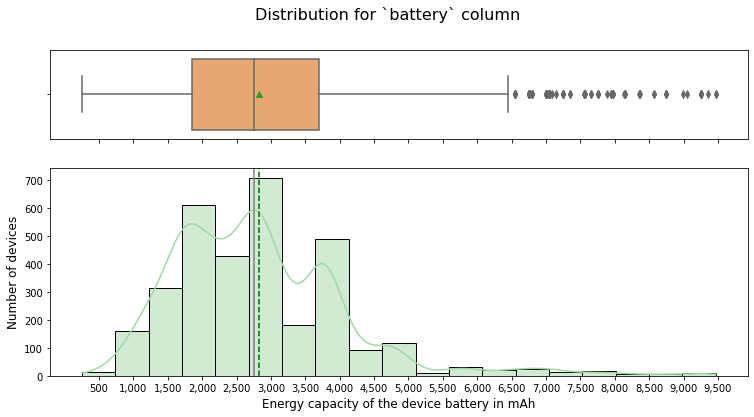

<IPython.core.display.Javascript object>

In [22]:
histogram_boxplot(data=df.dropna(), feature='battery', step=500, fmt='{:,.0f}', figsize=(12.5, 6),
                  xlabel='Energy capacity of the device battery in mAh')

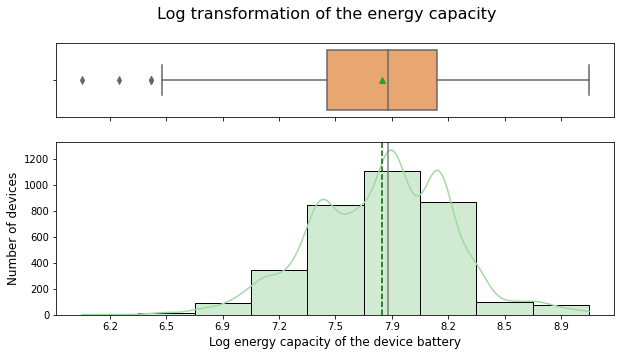

<IPython.core.display.Javascript object>

In [23]:
# Log transformation of the energy capacity
bat = df[['battery']].dropna()
bat['battery'] = bat['battery'].map(np.log)
histogram_boxplot(data=bat, feature='battery', bins=9, 
                  title='Log transformation of the energy capacity',
                  xlabel='Log energy capacity of the device battery')

* The battery distribution has many outliers on the right
* There are several more frequent values: 2000mAh, 3000mAh, 4000mAh
* The normalized battery capacity looks multimodal, with three outliers on the left
* The battery amount is approximately 3100 mAh on average
* The range is from 500mAh to 9720mAh
* It seems that log-transformation of this variable might be usefult for the modeling

**`weight`**

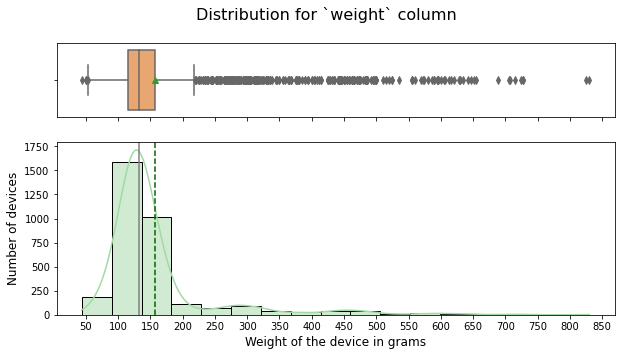

<IPython.core.display.Javascript object>

In [24]:
histogram_boxplot(data=df.dropna(), feature='weight', step=50, fmt='{:.0f}',
                  xlabel='Weight of the device in grams')

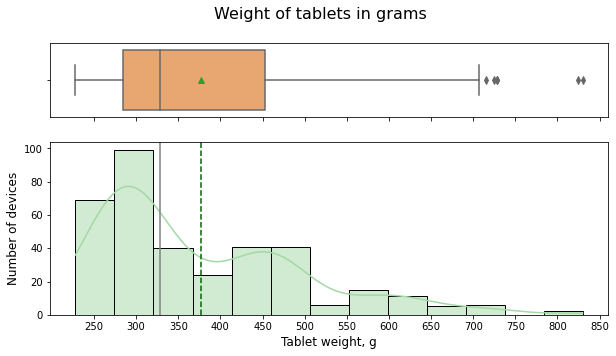

<IPython.core.display.Javascript object>

In [25]:
# Tablets
wt = df[['weight']].dropna()
wt['type'] = wt['weight'].apply(lambda x: 'tablet' if x > 250 else 'phone')
histogram_boxplot(data=wt[wt['type']=='tablet'], feature='weight', step=50,
                  title='Weight of tablets in grams', fmt='{:.0f}',
                  xlabel='Tablet weight, g')

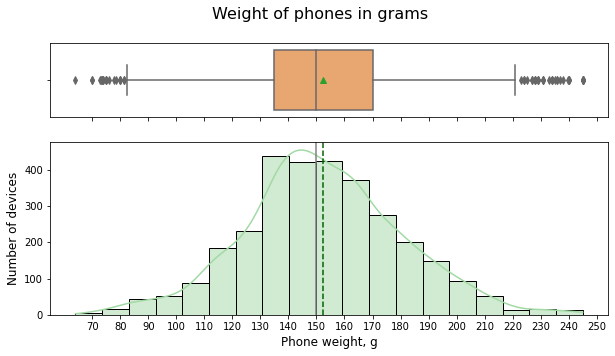

<IPython.core.display.Javascript object>

In [26]:
# Phones
histogram_boxplot(data=wt[wt['type']=='phone'], feature='weight', step=10,
                  title='Weight of phones in grams', fmt='{:.0f}',
                  xlabel='Phone weight, g')

* The weight distribution has many outliers on both sides
* Heavy devices (>250g) might be considered tablets (to be verified together with the screen size)
* Heavier devices (tablets):
  * The distribution is multimodal, right-skewed
  * The weight is approximately 400g on average (median is ~350g)
  * The range is from 250g to 850g (250g is the assumed threshold)
* Lighter devices (phones):
  * The distribution is bell-shaped, close to normal, with many outliers on both sides
  * The weight is approximately 160g on average
  * The range is from 69g to 250g (as the assumed threshold)

**`screen_size`**

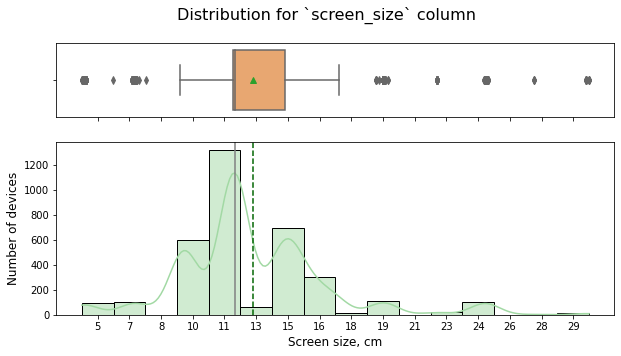

<IPython.core.display.Javascript object>

In [27]:
histogram_boxplot(data=df, feature='screen_size',
                  xlabel='Screen size, cm', fmt='{:.0f}',)

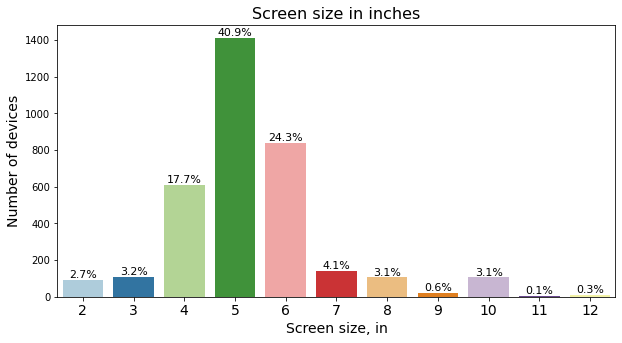

<IPython.core.display.Javascript object>

In [28]:
si = df[['screen_size']]/2.54
si['screen_size'] = si['screen_size'].map(int)
labeled_barplot(data=si, feature='screen_size',
                perc=True, n=None, percfmt="{:.1f}%", sort=False,
                figsize=(10, 5), xlabel='Screen size, in', xlo=0,
                title='Screen size in inches')

* The screen size distribution is right-skewed, multi-modal
* Screen size is approximately 13.7 cm on average
* The range is 5.1cm - 30.7cm (2" - 12")
* The most frequent (~41%) screen size is 12.7cm (5")
* There are outliers below and above the overall pattern in a distribution
* Gaps on the histogram are caused by the conversion of inches to cm (screen sizes are usually given in inches)
* The distribution of screen size in inches is right-skewed, close to normal
* Devices with a screen size of more than 6.7" (17 cm) are highly likely tablets

**`days_used`**

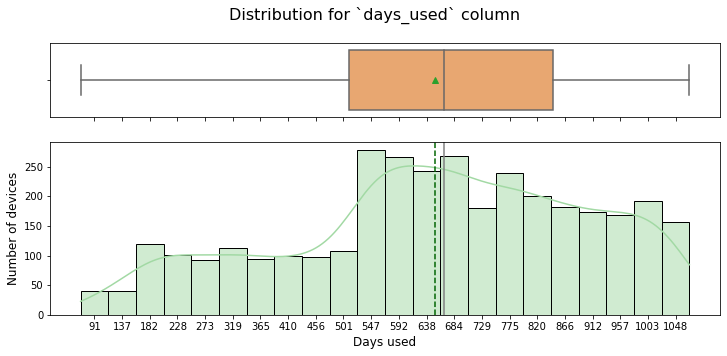

<IPython.core.display.Javascript object>

In [29]:
histogram_boxplot(data=df, feature='days_used', xlabel='Days used', fmt='{:.0f}', figsize=(12, 5))

* The `days_used` distribution seems to be close to uniform distribution
* The range is between 91 and 1094 days (approx. 3 years)
* There are two subsets: devices used less than 1.5 years and more
* Most of the devices were in use for about 1.7 years
* Least of the devices were in use for less than six months
* The `days_used` column seems to be negatively correlated with the `release_year`

**`main_camera_mp`**

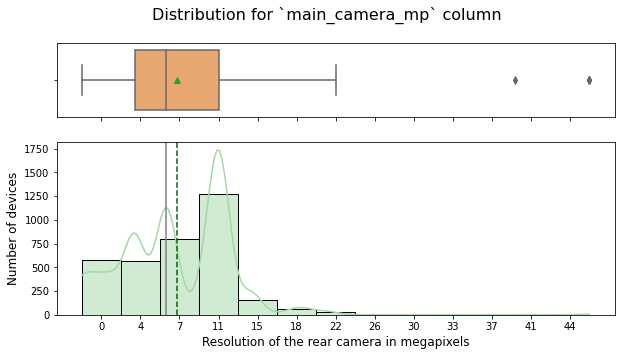

<IPython.core.display.Javascript object>

In [30]:
histogram_boxplot(data=df.fillna(0), feature='main_camera_mp', fmt='{:.0f}',
                  xlabel='Resolution of the rear camera in megapixels')

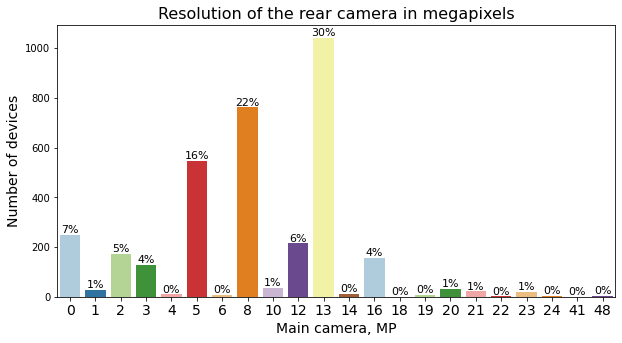

<IPython.core.display.Javascript object>

In [31]:
mc = pd.DataFrame(df['main_camera_mp'].fillna(0).map(int))
labeled_barplot(data=mc, feature='main_camera_mp', 
                perc=True, n=None, percfmt="{:.0f}%", sort=False,
                figsize=(10, 5), xlabel='Main camera, MP', xlo=0,
                title='Resolution of the rear camera in megapixels')

* The main camera resolution is approximately 9.5MP on average
* The range is 265KP - 48MP
* The most frequent (~30%) main camera resolution is 13MP
* There are five outliers: one 41MP and four 48MP, one device with 0.08MP (probably a mistake)
* 7% of devices have a main camera resolution less than 1MP

**`selfie_camera_mp`**

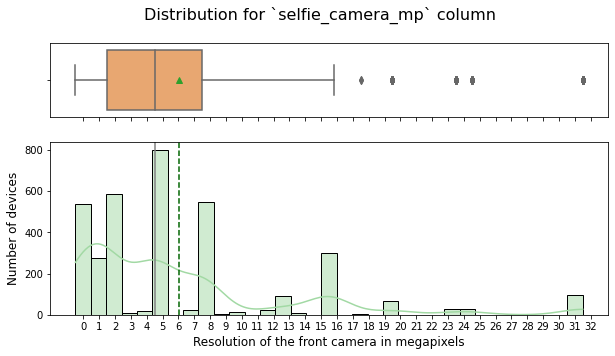

<IPython.core.display.Javascript object>

In [32]:
histogram_boxplot(data=df.fillna(0), feature='selfie_camera_mp', fmt='{:.0f}', step=1,
                  xlabel='Resolution of the front camera in megapixels')

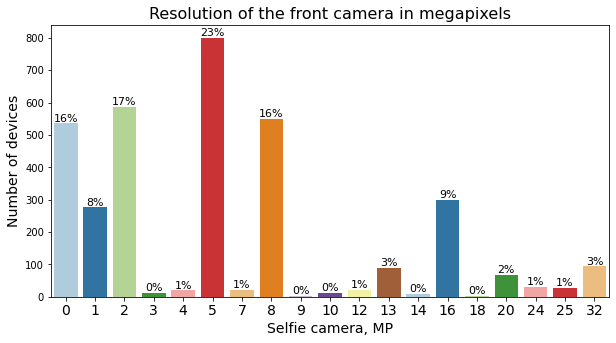

<IPython.core.display.Javascript object>

In [33]:
sc = pd.DataFrame(df['selfie_camera_mp'].fillna(0).map(int))
labeled_barplot(data=sc, feature='selfie_camera_mp', 
                perc=True, n=None, percfmt="{:.0f}%", sort=False,
                xlabel='Selfie camera, MP', xlo=0,
                title='Resolution of the front camera in megapixels')

* The selfie camera resolution is approximately 6.6MP on average
* The range is 256KP- 32MP
* The most frequent (~23%) main camera resolution is 5MP
* There are five outliers - more than 16MP selfie camera
* About 15% devices have a main camera resolution less than 1MP
* 39 devices do not have a selfie camera

**`int_memory`**

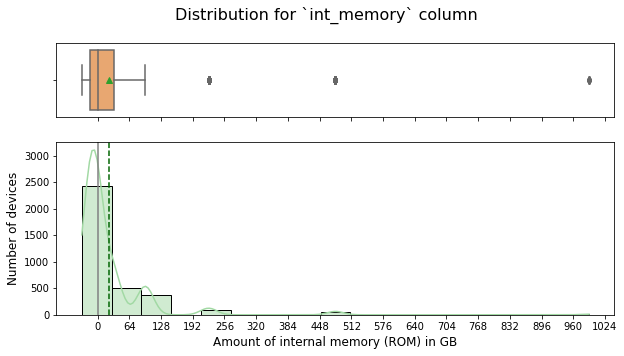

<IPython.core.display.Javascript object>

In [34]:
histogram_boxplot(data=df, feature='int_memory', fmt='{:.0f}', step=64,
                  xlabel='Amount of internal memory (ROM) in GB')

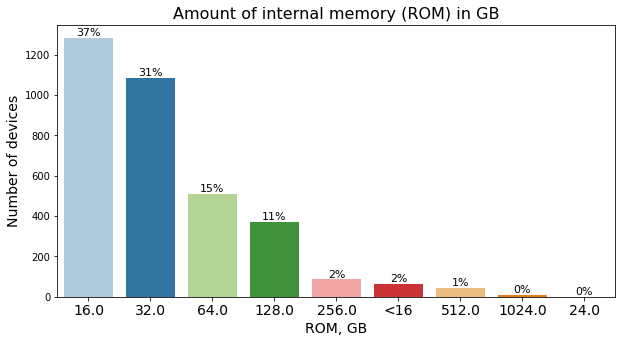

<IPython.core.display.Javascript object>

In [35]:
rom = df[['int_memory']].dropna()
rom['int_memory'] = rom['int_memory'].apply(lambda x: '<16' if x<16 else x)
labeled_barplot(data=rom, feature='int_memory', rnd=0,
                perc=True, n=None, percfmt="{:.0f}%", sort=True,
                figsize=(10, 5), xlabel='ROM, GB', xlo=0,
                title='Amount of internal memory (ROM) in GB')

* The int_memory amount is approximately 55GB on average
* The range is wide - from 8MB to 1TB
* The most frequent (~37%) ROM amount is 16GB
* There are three outliers - 256GB, 512GB, 1024GB

**`ram`**

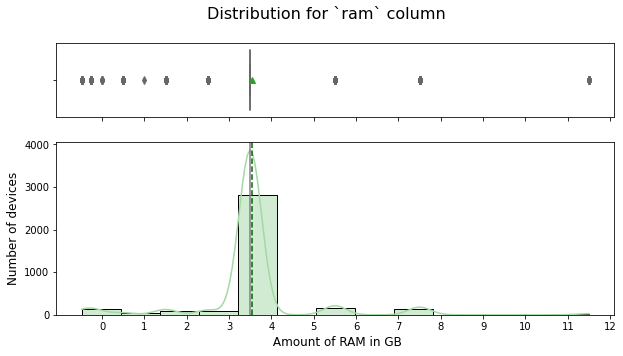

<IPython.core.display.Javascript object>

In [36]:
histogram_boxplot(data=df, feature='ram', step=1, fmt='{:.0f}',
                  xlabel=' Amount of RAM in GB')

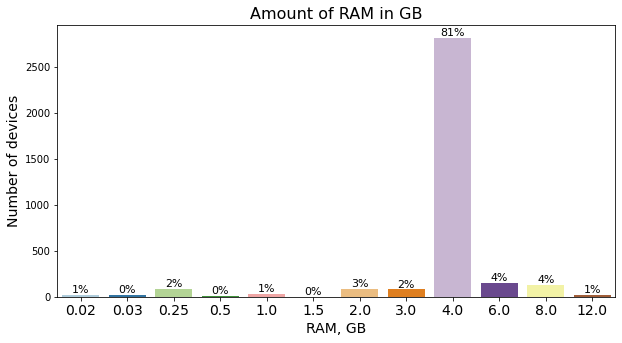

<IPython.core.display.Javascript object>

In [37]:
labeled_barplot(data=df, feature='ram', rnd=0,
                perc=True, n=None, percfmt="{:.0f}%", sort=False,
                figsize=(10, 5), xlabel='RAM, GB', xlo=0,
                title='Amount of RAM in GB')

* The RAM amount is approximately 4GB on average
* The range is 16MB and 12GB
* The most frequent (~81%) RAM amount is 4GB
* All values except 4GB may be considered outliers

### Discrete variable

**`year_release`**

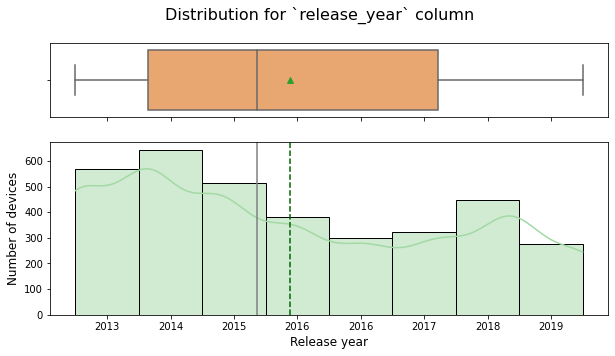

<IPython.core.display.Javascript object>

In [38]:
histogram_boxplot(data=df, feature='release_year', xlabel='Release year', fmt='{:.0f}')

* The year of release distribution seems to be close to uniform distribution
* The range is eight years - from 2013 to 2022
* Most of the devices were released in 2014
* The least of the devices were released in 2020

### Categorical variables

**`4g`**



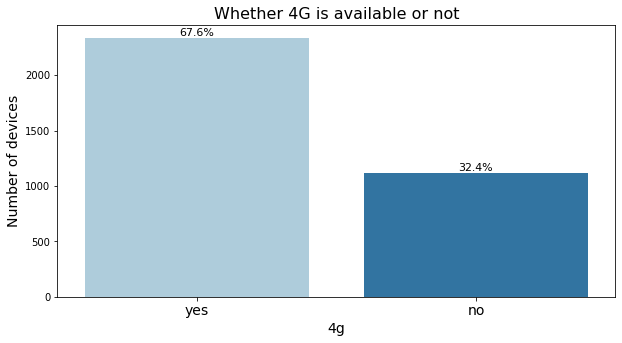

<IPython.core.display.Javascript object>

In [39]:
labeled_barplot(data=df, feature='4g', xlabel='4g', perc=True, 
                title='Whether 4G is available or not')

* The 4g technology is available in ~68% of the devices

**`5g`**

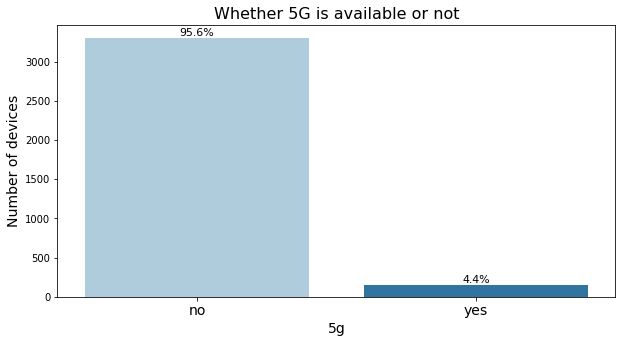

<IPython.core.display.Javascript object>

In [40]:
labeled_barplot(data=df, feature='5g', xlabel='5g', perc=True, title='Whether 5G is available or not')

* The 5g technology is available in ~4% of the devices

**`os`**

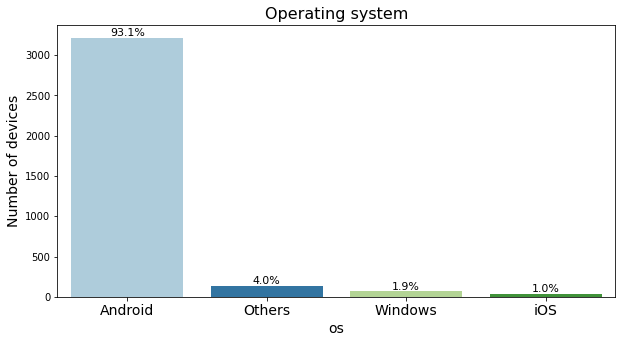

<IPython.core.display.Javascript object>

In [41]:
labeled_barplot(data=df, feature='os', xlabel='os', perc=True, title='Operating system')

* There are four OS in the dataset
* 93% devices run on Android

**`brand_name`**

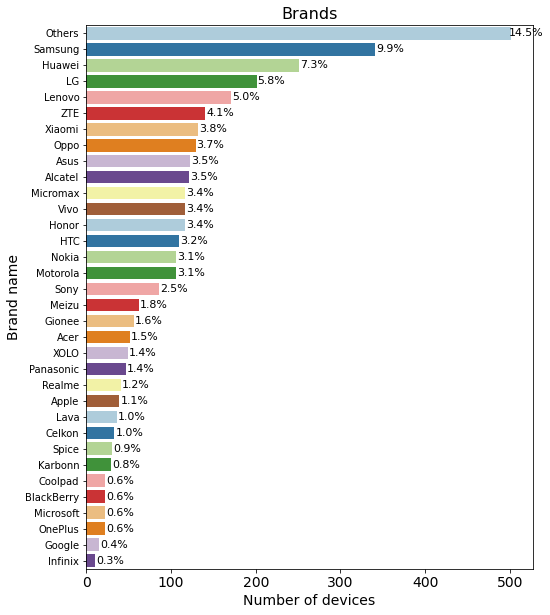

<IPython.core.display.Javascript object>

In [42]:
labeled_barplot(data=df, feature='brand_name', xlabel='Brand name', 
                figsize=(8, 10), perc=True, title='Brands', orient='v')

* There are 34 manufacturing brands in the dataset
* 14.5% of devices are from other brands
* Highest number of devices of the known brand is from Samsung (9.9%)
* Lowest number of devices of the known brand is from Infinix (0.3%)

## Bivariate analysis

Pairplot of continuous numerical variables

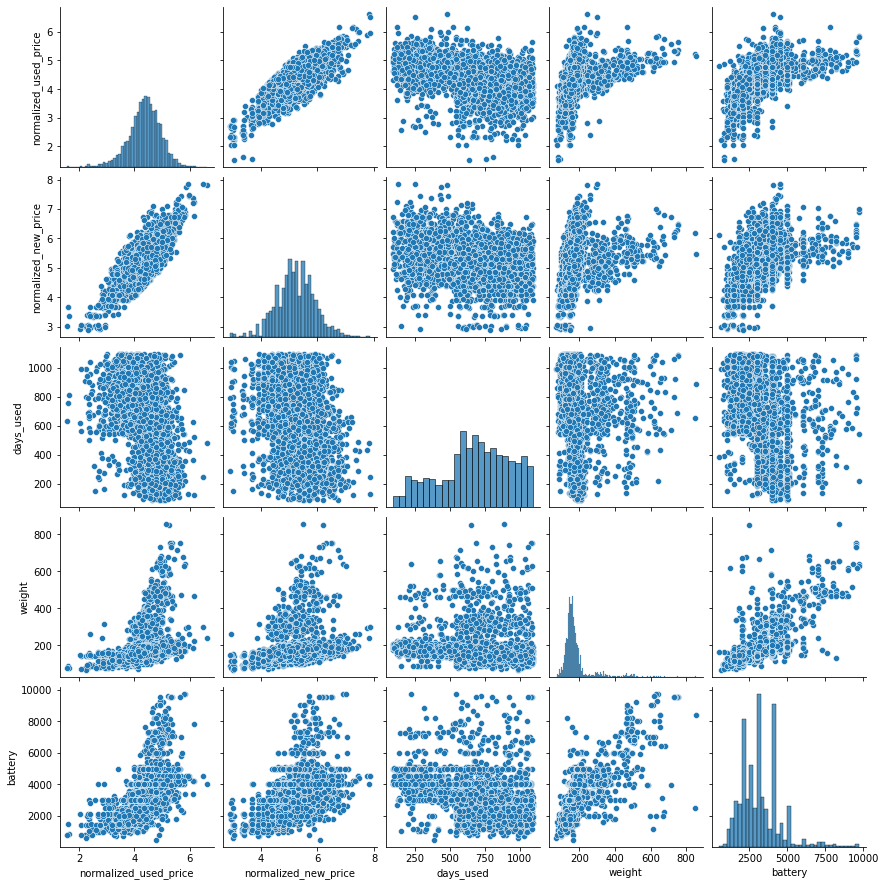

<IPython.core.display.Javascript object>

In [43]:
num_cols = ['normalized_used_price', 'normalized_new_price', 'days_used', 'weight', 'battery']
sns.pairplot(df[num_cols]);

* Visuzlly, the normalized new and used prices are sntrongly positevely correlated
* The weight and battery seem to be  positevely correlated
* Weight and price are correlated and it seems there are two subsets of data

**`Correlation heatmap`**

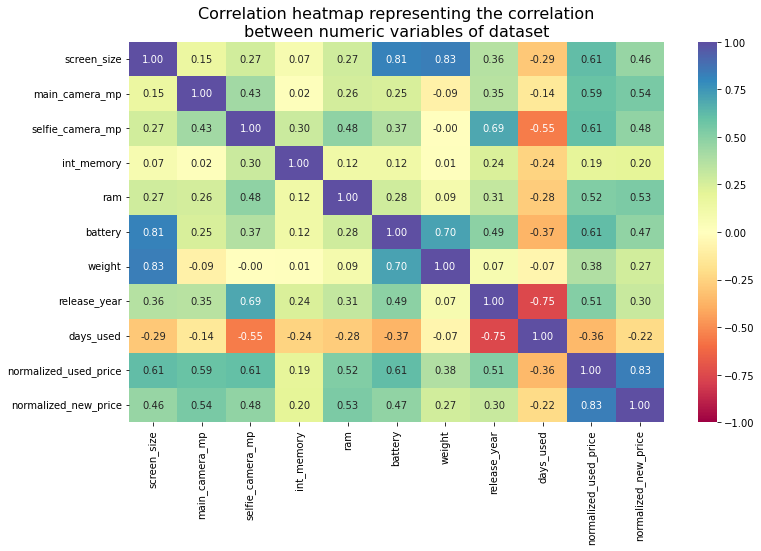

<IPython.core.display.Javascript object>

In [44]:
plt.figure(figsize=(12, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation heatmap representing the correlation\nbetween numeric variables of dataset', fontsize=16)
plt.show();

* `screen_size`, `battery`, and `weight` are mutually strongly correlated (but not always one caused another), as all three tie each other thru device size - the size of the device is strongly influenced by all three factors
* `normalized_new_price` and `normalized_used_price` have a strong positive correlation
* `release_year` and `days_used` have a strong negative correlation
* moderate positive correlation between `selfie_camera_mp` and `release_year` might be explained by the technical development and improvements of the camera capacity within the last eight years

**`release_year`** and **`days_used`**

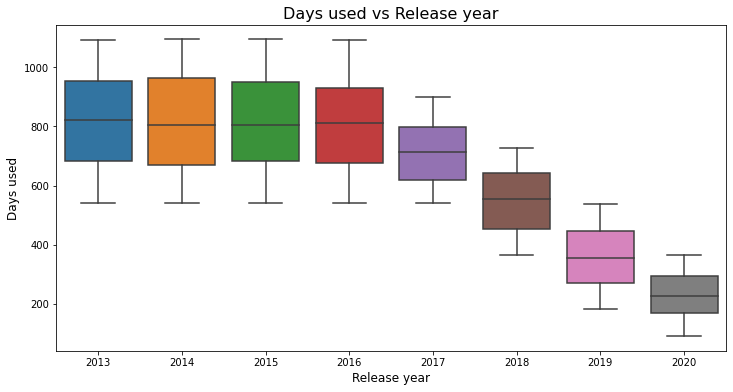

<IPython.core.display.Javascript object>

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df, x='release_year', y='days_used', ax=ax)
plt.xlabel('Release year', fontsize=12)
plt.ylabel('Days used', fontsize=12)
plt.title('Days used vs Release year', fontsize=16)
plt.show()

* Distributions of the number of days being in used for devices issued in 2013-2016 look the same
* The average time of usage for devices released more than 4 years ago (in 2013-2016) is ~815 days (2 years and 3 months)
* Since 2017 the average usage time decreased by 5 months on average every year
* Devices issued in 2020 were in use on average for 229 days (7 months)

**`release_year`** and **`normalized_used_price`**

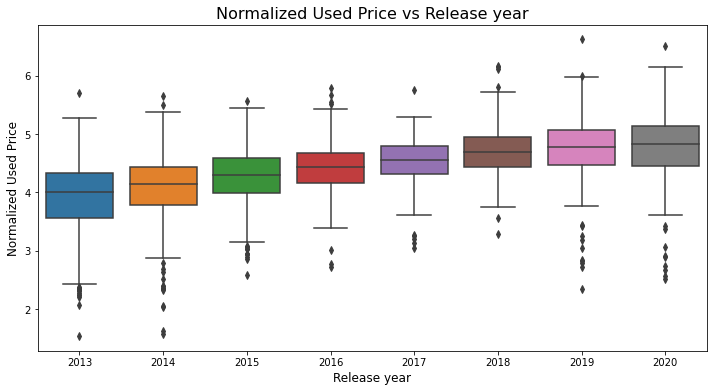

<IPython.core.display.Javascript object>

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df, x='release_year', y='normalized_used_price', ax=ax)
plt.xlabel('Release year', fontsize=12)
plt.ylabel('Normalized Used Price', fontsize=12)
plt.title('Normalized Used Price vs Release year', fontsize=16)
plt.show()

* The average normalized used price was growing with the release year


**`screen_size`** and **`normalized_used_price`**

In [47]:
round(df['screen_size']/2.54,0).value_counts()

5.0     1360
6.0      762
4.0      598
7.0      284
8.0      112
10.0     106
3.0      106
2.0       92
9.0       20
12.0      11
11.0       3
Name: screen_size, dtype: int64

<IPython.core.display.Javascript object>

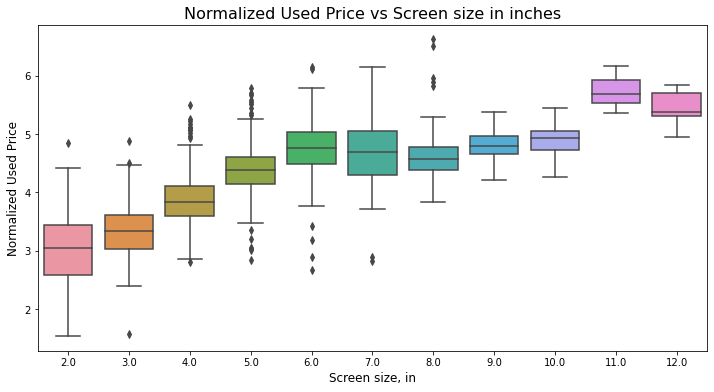

<IPython.core.display.Javascript object>

In [48]:
ssnp = df[['screen_size', 'normalized_used_price']]
ssnp['screen_size_in'] = round(ssnp['screen_size']/2.54,0)

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=ssnp, x='screen_size_in', y='normalized_used_price', ax=ax)
plt.xlabel('Screen size, in', fontsize=12)
plt.ylabel('Normalized Used Price', fontsize=12)
plt.title('Normalized Used Price vs Screen size in inches', fontsize=16)
plt.show()

* Average normalized used price is growing with screen size increase until 6"
* The average prices are stable for devices with screen sizes from 6" to 10"
* Devices with screen sizes 8" and mor are tablets
* Prices for tablets grow significantly for devices with a screen size of 11" and more

**`os`** and **`normalized_used_price`**

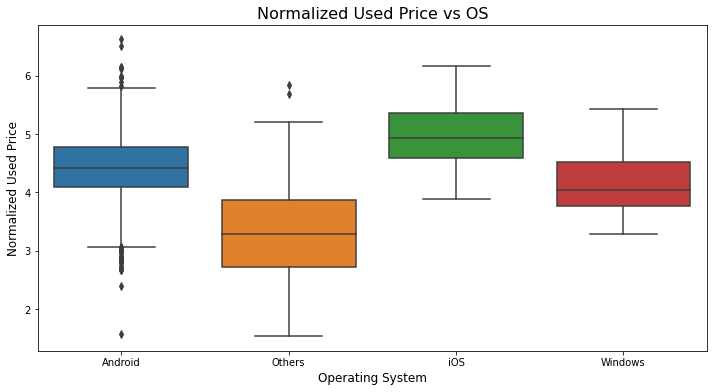

<IPython.core.display.Javascript object>

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df, x='os', y='normalized_used_price', ax=ax)
plt.xlabel('Operating System', fontsize=12)
plt.ylabel('Normalized Used Price', fontsize=12)
plt.title('Normalized Used Price vs OS', fontsize=16)
plt.show()

* Average normalized used price is higher for iOS devices
* Average normalized used price is lower for Other devices
* Average normalized used price of Windows devices is lower than Android and iOS devices

**`weight`, `normalized_used_price`, `4g`/`5g`**

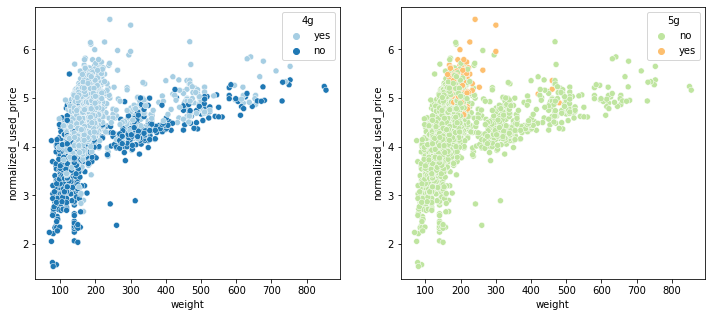

<IPython.core.display.Javascript object>

In [50]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
sns.scatterplot(data=df, x='weight', y='normalized_used_price', hue='4g', palette='Paired', ax=ax1);
sns.scatterplot(data=df, x='weight', y='normalized_used_price', hue='5g', palette='Spectral_r', ax=ax2);

* Assuming that devices heavier than 250g are tablets, we can conclude that
  * Devices with no 4g in general cost less in their segment
    * This is true for both phones and tablets, but the distinguish is more visible for the phones segment
  * Phones with 5g are in the top price segment
  * There are just a few tablets with 5g

**`5g`, `normalized_used_price`, `brand_name`, `release_year`**

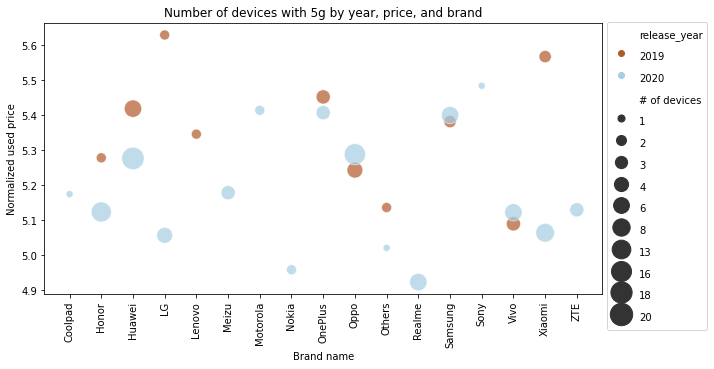

<IPython.core.display.Javascript object>

In [51]:
plt.figure(figsize=(10, 5))
comp = df[df['5g']=='yes'].groupby(['brand_name','release_year']).agg({'normalized_used_price': 'mean', '5g': 'count', 'weight': 'mean'}).reset_index()
comp = comp.rename(columns = {'5g': '# of devices'})
sizes = [50*n for n in range(1, 11)]
sns.scatterplot(data=comp, x='brand_name', y='normalized_used_price', hue='release_year', size='# of devices', palette='Paired_r', 
                sizes=sizes, alpha=0.7);
plt.title('Number of devices with 5g by year, price, and brand')
plt.xlabel('Brand name')
plt.ylabel('Normalized used price')
plt.xticks(rotation=90);
plt.legend(bbox_to_anchor=(1.0, 1.02), handleheight=2.2);

* Prices of devices with 5g released in 2020 dropped for most of the brands in comparison to 2019
* The average price of devices from Samsung, Oppo, and Vivo released in 2020 is slightly higher than the average price of their devices released in 2019
* There were 9 brands with devices released in 2019 with 5g. 7 more brands joined them in 2020
* THere were a few devices with 5g by Lenovo released in 2019, but no devices with 5g released in 2020 from this brand in our dataset

## Additional analysis

* We can not create a new variable related to the dependent variable and add it to the model. However, it is essential to investigate the derivative variable `discount` and analyze its behavior for different groups or devices
* Let's create a temporary column `discount` as $1-{{normalized\_used\_price} \over {normalized\_new\_price}}$


In [52]:
df1 = df.copy()
df1['discount'] = 1 - df1['normalized_used_price'] / df1['normalized_new_price']

<IPython.core.display.Javascript object>

In [53]:
print(f'The aveage discount for all devices is {df1.discount.mean():.2%}')

The aveage discount for all devices is 16.43%


<IPython.core.display.Javascript object>

In [54]:
print(f'The aveage discount for devices with 5G is {df1[df1["5g"]=="yes"].mean()["discount"]:.2%}')
print(f'The aveage discount for devices w/o 5G is {df1[df1["5g"]=="no"].mean()["discount"]:.2%}')

The aveage discount for devices with 5G is 16.14%
The aveage discount for devices w/o 5G is 16.44%


<IPython.core.display.Javascript object>

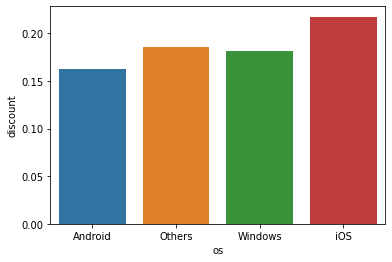

<IPython.core.display.Javascript object>

In [55]:
sns.barplot(data=df1.groupby('os').mean()[['discount']].reset_index(), x='os', y='discount');

In [56]:
del df1

<IPython.core.display.Javascript object>

* The average discount for used devices is ~16% off to new device price of the same model (in normalized prices)
* The highest discounts are for iOS devices (more than 20%).
* `Other` and `Windows` devices have higher discount that devices work on Android
* The aveage discount for devices w/o 5G is 0.3% higher than for devices with 5G
* **That might be important to explain the regression coefficents of the model**

## Questions:

1. What does the distribution of normalized used device prices look like?
2. What percentage of the used device market is dominated by Android devices?
3. The amount of RAM is important for the smooth functioning of a device. How does the amount of RAM vary with the brand?
4. A large battery often increases a device's weight, making it feel uncomfortable in the hands. How does the weight vary for phones and tablets offering large batteries (more than 4500 mAh)?
5. Bigger screens are desirable for entertainment purposes as they offer a better viewing experience. How many phones and tablets are available across different brands with a screen size larger than 6 inches?
6. A lot of devices nowadays offer great selfie cameras, allowing us to capture our favorite moments with loved ones. What is the distribution of devices offering greater than 8MP selfie cameras across brands?
7. Which attributes are highly correlated with the normalized price of a used device?

####**1. What does the distribution of normalized used device prices look like?**

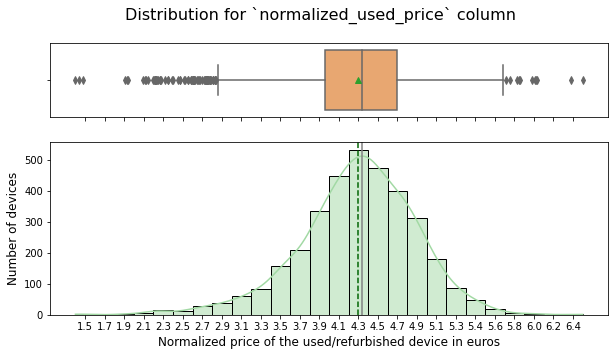

<IPython.core.display.Javascript object>

In [57]:
histogram_boxplot(data=df, feature='normalized_used_price',
                  xlabel='Normalized price of the used/refurbished device in euros')

In [58]:
# outliers

iqr15 = 1.5*st.iqr(df['normalized_used_price'])
outs = ((df['normalized_used_price']<(df['normalized_used_price'].quantile(0.25) - iqr15)).sum(),
        (df['normalized_used_price']>(df['normalized_used_price'].quantile(0.75) + iqr15)).sum())

print(f'There are {outs[0]} and {outs[1]} outliers below and above respectively the overall pattern in a distribution.')


There are 74 and 11 outliers below and above respectively the overall pattern in a distribution.


<IPython.core.display.Javascript object>

* The normalized used device price variable look symmetric (bell shaped), unimodal, close to normally distributed
* Normalized used device price is approximately 4.4 on average (the range is 1.54-6.62)
* There are 74 and 11 outliers below and above the overall pattern in a distribution respectively
* It seems that the original prices in euros were converted to the normalized form with the log transformation

####**2. What percentage of the used device market is dominated by Android devices?**

In [59]:
display(pd.concat({'Frequency': df.value_counts('os', normalize=False), 
                   'Percentage': df.value_counts('os', normalize=True)}, axis=1) \
        .style.format({'Frequency': '{:,.0f}'.format, 
                       'Percentage': '{:.1%}'.format}))

print(f'\n\033[1mTotal:\033[0m {df.shape[0]:,.0f} devices.')


Total: 3,454 devices.


<IPython.core.display.Javascript object>

* 93.1% of the used device market is dominated by Android devices

####**3. The amount of RAM is important for the smooth functioning of a device. How does the amount of RAM vary with the brand?**

In [60]:
# top 5 RAM amount devices
display(pd.concat({'Frequency': df.value_counts('ram', normalize=False), 
                   'Percentage': df.value_counts('ram', normalize=True)}, 
                  axis=1).head(5).style.format({'Frequency': '{:,.0f}'.format, 
                                               'Percentage': '{:.1%}'.format}))


<IPython.core.display.Javascript object>

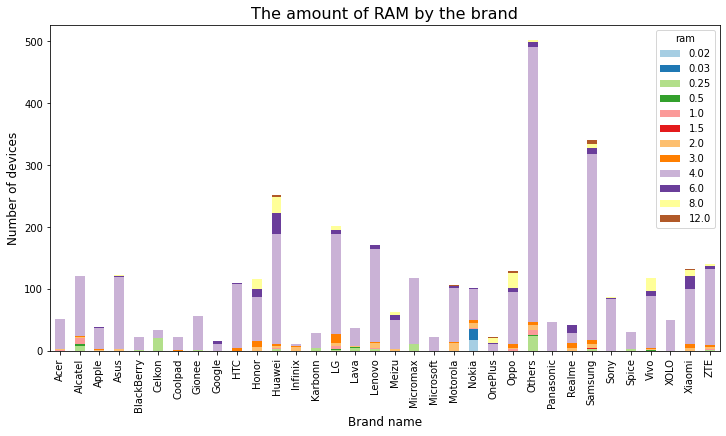

<IPython.core.display.Javascript object>

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))
pd.crosstab(index=df['brand_name'], columns=df['ram']).plot(
    kind='bar', stacked=True, color=sns.color_palette('Paired'), ax=ax)
plt.xlabel('Brand name', fontsize=12)
plt.ylabel('Number of devices', fontsize=12)
plt.title('The amount of RAM by the brand', fontsize=16)
plt.show()

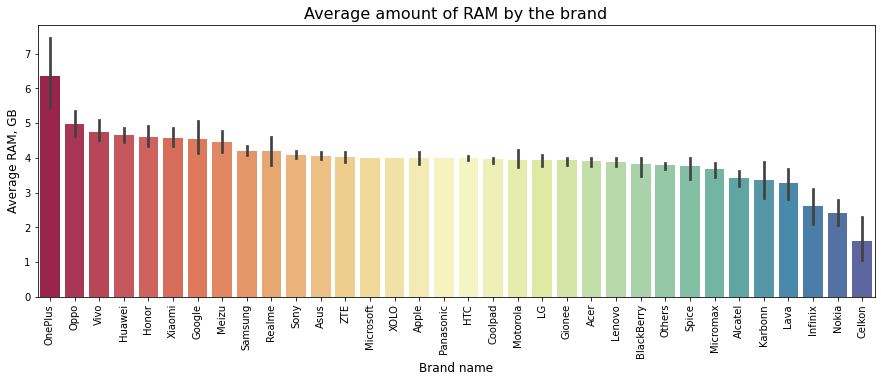

<IPython.core.display.Javascript object>

In [62]:
plt.figure(figsize=(15, 5))
sns.barplot(data=df, x="brand_name", y="ram", palette='Spectral',
            order=df.groupby('brand_name').mean()['ram'].sort_values()[::-1].index)
plt.xticks(rotation=90)
plt.xlabel('Brand name', fontsize=12)
plt.ylabel('Average RAM, GB', fontsize=12)
plt.title('Average amount of RAM by the brand', fontsize=16)
plt.show()

In [63]:
# Variety of ram among a brand's devices
df[['brand_name', 'ram']].drop_duplicates().value_counts('brand_name').head()

brand_name
Samsung    9
Others     8
Nokia      8
Huawei     8
LG         8
dtype: int64

<IPython.core.display.Javascript object>

In [64]:
print(f"{df[df['ram']==df['ram'].min()].value_counts('brand_name').index.values} has models with minimum RAM")
print(f"{df[df['ram']==df['ram'].max()].value_counts('brand_name').index.values} has models with maximum RAM")

['Nokia'] has models with minimum RAM
['Samsung' 'Oppo' 'Huawei' 'Motorola' 'OnePlus' 'Xiaomi'] has models with maximum RAM


<IPython.core.display.Javascript object>

* Overwhelming majority of the devices have 4GB RAM (4GB of RAM is in 81.6% of devices)
* All other amounts except 4GB might be considered as outliers
* Samsung is the brand with largest variety of models with different amounts of RAM
* Nokia is the brand that has models with minimal RAM of 16MB
* Several brands have models with a maximum RAM of 12 GB
* The maximum average amount of RAM is observed in the OnePlus brand
* The minimum average amount of RAM is observed in the Celcon brand

####**4. A large battery often increases a device's weight, making it feel uncomfortable in the hands. How does the weight vary for phones and tablets offering large batteries (more than 4500 mAh)?**

In [65]:
bw = data=df[df['battery']>4500]
bw[['weight','battery']].corr()

weight   battery
weight   1.000000  0.757622
battery  0.757622  1.000000

<IPython.core.display.Javascript object>

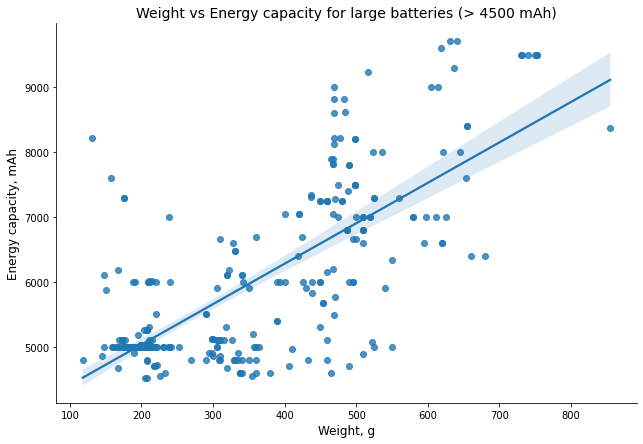

<IPython.core.display.Javascript object>

In [66]:
sns.lmplot(x='weight', y='battery', data=bw, height=6, aspect=1.5)
plt.xlabel('Weight, g', fontsize=12)
plt.ylabel('Energy capacity, mAh', fontsize=12)
plt.title('Weight vs Energy capacity for large batteries (> 4500 mAh)', fontsize=14)
plt.show();


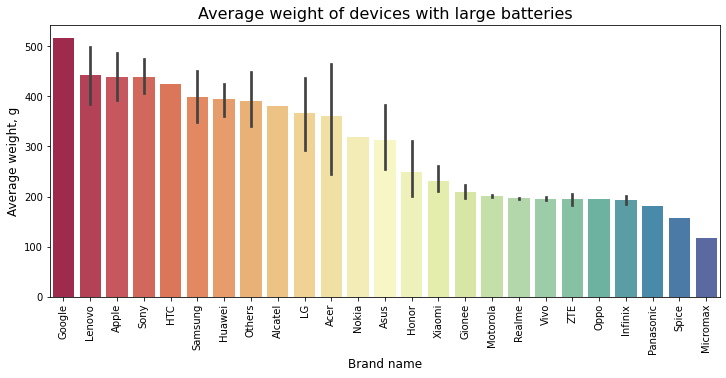

<IPython.core.display.Javascript object>

In [67]:
plt.figure(figsize=(12, 5))
sns.barplot(data=bw, x="brand_name", y="weight", palette='Spectral',
            order=bw.groupby('brand_name').mean()['weight'].sort_values()[::-1].index)
plt.xticks(rotation=90)
plt.xlabel('Brand name', fontsize=12)
plt.ylabel('Average weight, g', fontsize=12)
plt.title('Average weight of devices with large batteries', fontsize=16)
plt.show()

* The relationship between weight and energy capacity for devices with large batteries is considered strong as coefficient correlation is larger than 0.7
* The heaviest device with a large battery is manufactured by Google (517g)
* Lightest device with a large battery is manufactured by Micromax (118g)
* Acer is the brand with largest variety of models with different weights of devices with a large battery
* Devices with weight more than 250g are mostly tablets. Considering also that weight and batary are strongly correlated, we can conclude that most of the devices with large batteries are tablets

####**5. Bigger screens are desirable for entertainment purposes as they offer a better viewing experience. How many phones and tablets are available across different brands with a screen size larger than 6 inches?**

In [68]:
bs = df[df['screen_size']>6*2.54]
bs.value_counts('brand_name', normalize=True).head()

brand_name
Huawei     0.135578
Samsung    0.108280
Others     0.090082
Vivo       0.072793
Honor      0.065514
dtype: float64

<IPython.core.display.Javascript object>

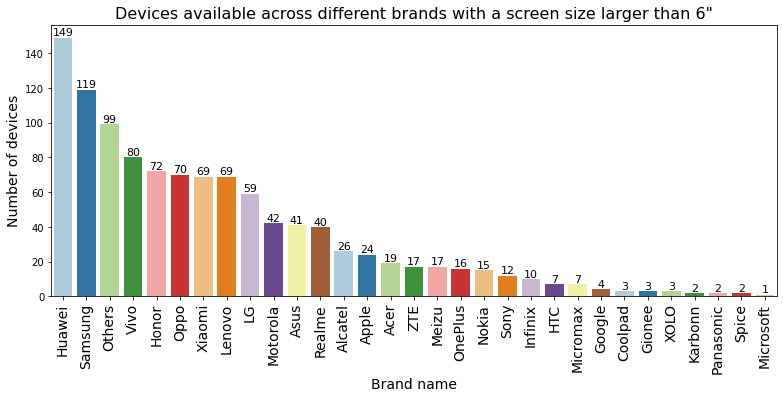

<IPython.core.display.Javascript object>

In [69]:
labeled_barplot(data=bs, feature='brand_name', perc=False, 
                xlabel='Brand name', figsize=(13,5), xlo=90,
                title='Devices available across different brands with a screen size larger than 6"')

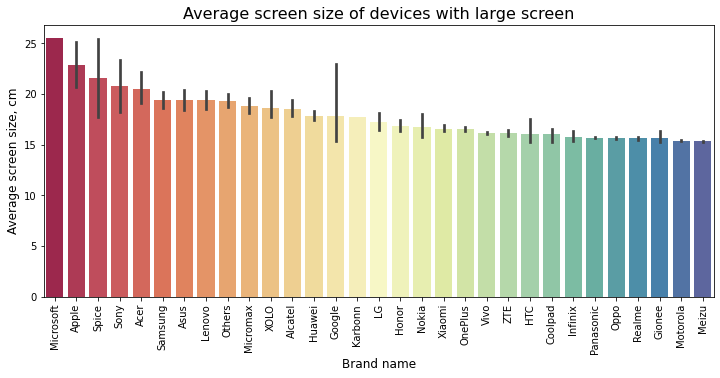

<IPython.core.display.Javascript object>

In [70]:
plt.figure(figsize=(12, 5))
sns.barplot(data=bs, x="brand_name", y="screen_size", palette='Spectral',
            order=bs.groupby('brand_name').mean()['screen_size'].sort_values()[::-1].index)
plt.xticks(rotation=90)
plt.xlabel('Brand name', fontsize=12)
plt.ylabel('Average screen size, cm', fontsize=12)
plt.title('Average screen size of devices with large screen', fontsize=16)
plt.show()

* Huawei is the brend with maximum number of devices (149, ~13.6%) with screen size larger than 6"
* Micosoft is the brand with minimum number of devices (1) with screen size larger than 6"
* The largest average screen size belongs to Microsoft device (25.6cm, 10")
* The smallest average screen size belongs to Meizu devices (15.3cm, ~6")
* Google is the brand with largest variety of models with different screen sizes of devices with a screen size large than 6"

####**6. A lot of devices nowadays offer great selfie cameras, allowing us to capture our favorite moments with loved ones. What is the distribution of devices offering greater than 8MP selfie cameras across brands?**

In [71]:
bc = df[df['selfie_camera_mp']>8]
print(bc.value_counts('brand_name', normalize=False).head())
print(bc.value_counts('brand_name', normalize=False).tail())

brand_name
Huawei     87
Vivo       78
Oppo       75
Xiaomi     63
Samsung    57
dtype: int64
brand_name
Coolpad       3
Micromax      2
Panasonic     2
BlackBerry    2
Acer          1
dtype: int64


<IPython.core.display.Javascript object>

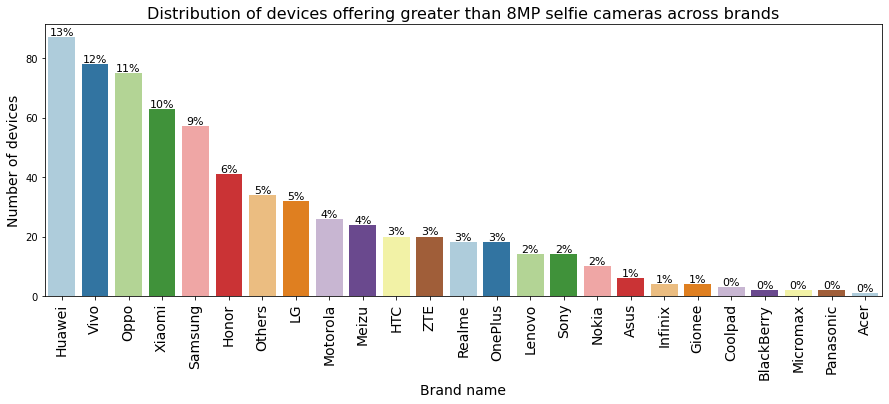

<IPython.core.display.Javascript object>

In [72]:
labeled_barplot(data=bc, feature='brand_name', perc=True, percfmt='{:.0f}%',
                xlabel='Brand name', figsize=(15,5), xlo=90,
                title='Distribution of devices offering greater than 8MP selfie cameras across brands')

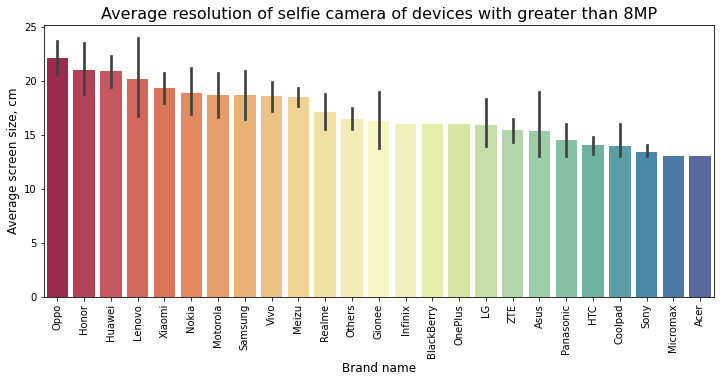

<IPython.core.display.Javascript object>

In [73]:
plt.figure(figsize=(12, 5))
sns.barplot(data=bc, x="brand_name", y='selfie_camera_mp', palette='Spectral',
            order=bc.groupby('brand_name').mean()['selfie_camera_mp'].sort_values()[::-1].index)
plt.xticks(rotation=90)
plt.xlabel('Brand name', fontsize=12)
plt.ylabel('Average screen size, cm', fontsize=12)
plt.title('Average resolution of selfie camera of devices with greater than 8MP', fontsize=16)
plt.show()

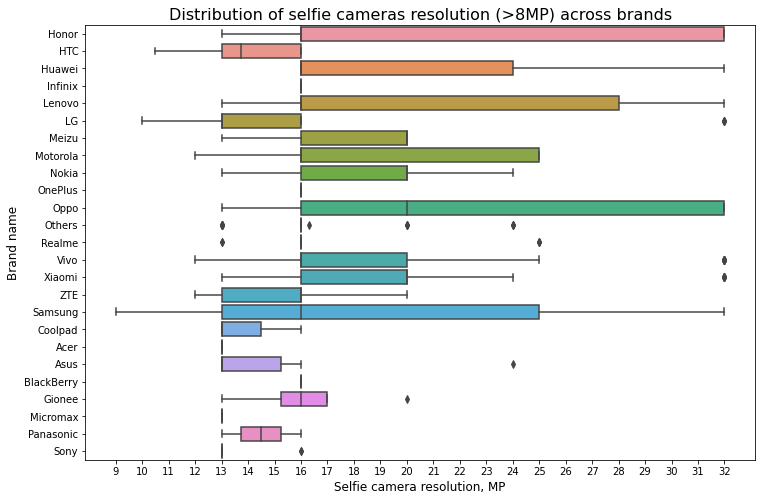

<IPython.core.display.Javascript object>

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=bc, y="brand_name", x="selfie_camera_mp", ax=ax)
plt.xlabel('Selfie camera resolution, MP', fontsize=12)
plt.ylabel('Brand name', fontsize=12)
plt.title('Distribution of selfie cameras resolution (>8MP) across brands', fontsize=16)
ax.xaxis.set_major_formatter(tick.FormatStrFormatter('%0.0f'))
plt.xticks(np.arange(min(bc['selfie_camera_mp']), max(bc['selfie_camera_mp'])+1, 1))
plt.show()

* Huawei is the brand offering the maximum number of devices (87, ~13%) with greater than 8MP selfie cameras
* Acer is the brand offering one device with greater than an 8MP selfie camera
* Devices with the highest average selfie camera resolution belong to Oppo (22.12MP)
* Devices with the smallest average selfie camera resolution belong to Acer (13MP) among that higher 8MP
* Lenovo is the brand with the largest variety of models with different selfie camera resolutions of devices with a selfie camera resolution greater than 8MP

####**7. Which attributes are highly correlated with the normalized price of a used device?**

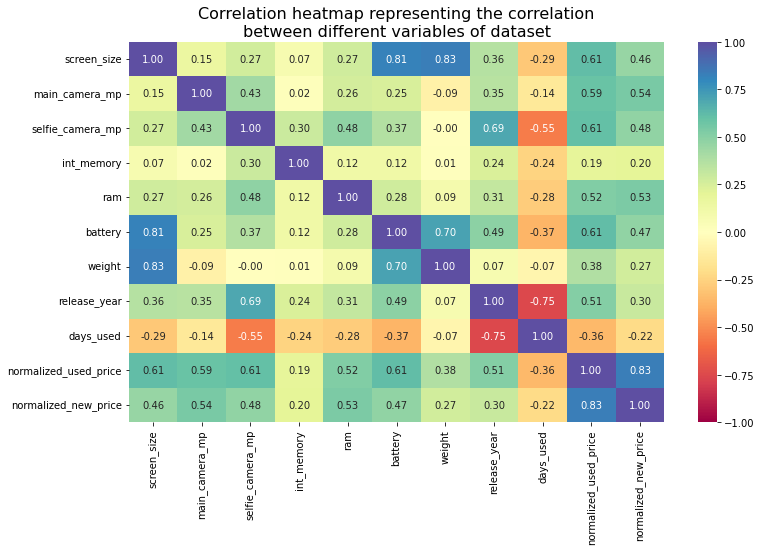

<IPython.core.display.Javascript object>

In [75]:
plt.figure(figsize=(12, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation heatmap representing the correlation\nbetween different variables of dataset', fontsize=16)
plt.show();

* The correlation coefficient of 0.83 indicates a strong positive correlation between the *normalized price of a used device* and *normalized price of a new device* of the same model
* The correlation coefficient of -0.36 indicates a weak negative correlation between the *normalized price of a used device* and number of days the used/refurbished device has been used
* The attributes positively correlated with the `normalized_used_price` are:
  * Moderate: `screen_size`, `main_camera_mp`, `selfie_camera_mp`, `ram`, `battery`, `release year`
  * Week: `weight`
  * No correlation: `int_memory` ($<$0.3)

**NB:** *In interpreting correlation it is important to remember that correlation is not causation. There may or may not be a causative connection between the two correlated variables.Moreover, if there is a connection it may be indirect.*

# Data Preprocessing

- Duplicate value check
- Missing value treatment
- Feature engineering (if needed)
- Outlier detection and treatment (if needed)
- Preparing data for modeling
- Any other preprocessing steps (if needed)

Let's create a copy of the dataset for preprocessing - `dfpp`

In [76]:
dfpp = df.copy()

<IPython.core.display.Javascript object>

##**Duplicate Value Check**

In [77]:
dfpp.duplicated().sum()

0

<IPython.core.display.Javascript object>

* There are no duplicate values in the dataset

##**Missing Value Treatment**

In [78]:
missed = dfpp.isnull().sum()
missed = missed[missed>0]

print('Columns with missing values:')
print(missed)
print(f'Missing values occur in about {missed.sum()/dfpp.shape[0]:.1%} of rows.')

Columns with missing values:
main_camera_mp      179
selfie_camera_mp      2
int_memory            4
ram                   4
battery               6
weight                7
dtype: int64
Missing values occur in about 5.8% of rows.


<IPython.core.display.Javascript object>

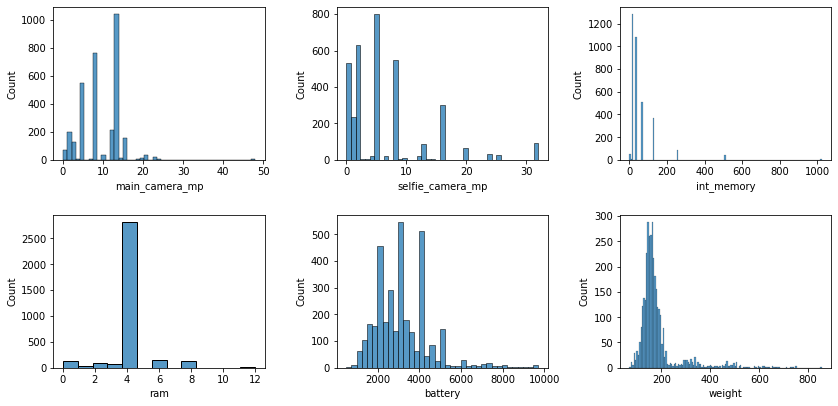

<IPython.core.display.Javascript object>

In [79]:
# distibution review using histplot

plt.figure(figsize=(12, 6))
for i, variable in enumerate(missed.index):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=dfpp, x=variable)
    plt.tight_layout(pad=2)

plt.show();

Let's fix the missing values in the data.
* For the variables contained missing values, we will impute the missing values in each column with the median grouped by `brand_name` as all of the columns have skewed distributions


In [80]:
# Filling NA with median by grouping by brand_name

for col in missed.index:
  dfpp[col] = dfpp[col].fillna(value=dfpp.groupby(['brand_name'])[col].transform('median'))

missed = dfpp.isnull().sum()
missed = missed[missed>0]

print('Columns with missing values:')
print(missed)

Columns with missing values:
main_camera_mp    10
dtype: int64


<IPython.core.display.Javascript object>

* After the first step of treating the missing values, there are still some missing values in the `main_camera_mp` column.
* We will input the remaining missing values in the `main_camera_mp` column with the median value of this column.

In [81]:
dfpp['main_camera_mp'] = dfpp['main_camera_mp'].fillna(value=dfpp['main_camera_mp'].median())

print(f'Total number of missed values in the dataset after transformation is {dfpp.isnull().sum().sum()}.')


Total number of missed values in the dataset after transformation is 0.


<IPython.core.display.Javascript object>

* Missing values in the columns imputed with median by grouping the data by `brand name` 
* Ten missing values of `main_camera_mp` column imputed with median of the column
* All the missing values in the dataset have been treated

##**Feature engineering (if needed)**

> Let's create a feature `type` to tag tablets and phones
based on  the `screen_size` column. 
* Assume that devices with screen size > 17cm (6.7") are tablets

In [82]:
dfpp['type'] = dfpp['screen_size'].apply(lambda x: 'tablet' if x > 6.7*2.54 else 'phone')
dfpp['type'].describe()

count      3454
unique        2
top       phone
freq       3052
Name: type, dtype: object

<IPython.core.display.Javascript object>

> Let's create a new column `years_since_release` from the release_year column
* We will consider the year of data collection, 2021, as the baseline
* We will drop the release_year column

In [83]:
dfpp['years_since_release'] = 2021 - dfpp['release_year']
dfpp = dfpp.drop('release_year', axis=1)
dfpp['years_since_release'].describe()

count    3454.000000
mean        5.034742
std         2.298455
min         1.000000
25%         3.000000
50%         5.500000
75%         7.000000
max         8.000000
Name: years_since_release, dtype: float64

<IPython.core.display.Javascript object>

##**Outlier detection and treatment (if needed)**

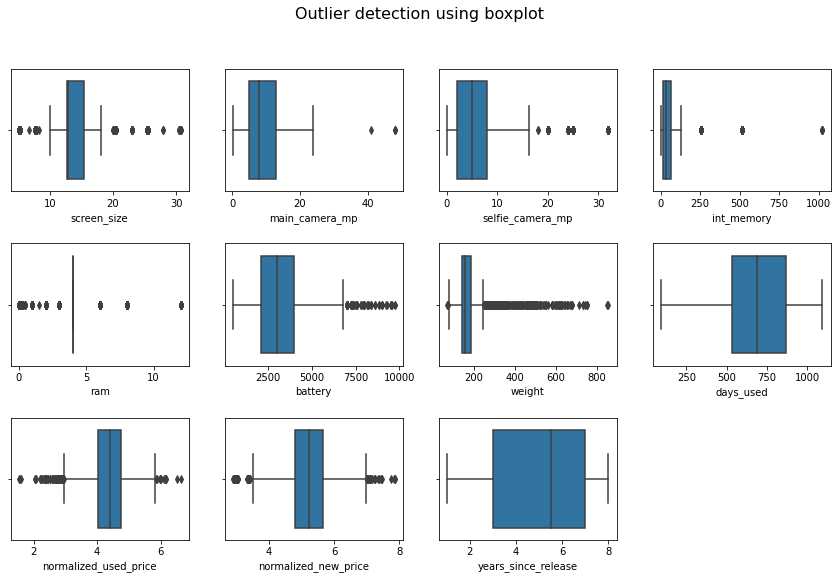

<IPython.core.display.Javascript object>

In [84]:
# outlier detection using boxplot
num_cols = dfpp.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(12, 10))
plt.suptitle('Outlier detection using boxplot', fontsize=16, y=1.01)

for i, variable in enumerate(num_cols):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(data=dfpp, x=variable)
    plt.tight_layout(pad=2)

plt.show();

In [85]:
# Use this code to remove outliers

#num_cols = df.select_dtypes(include=np.number).columns.tolist()

#for col in num_cols:
#  q1, q3 = df[col].quantile([0.25,0.75])
#  iqr = q3 - q1
#  df = df[(df[col] <= q3 + 1.5 * iqr) & (df[col] >= q1 - 1.5 * iqr)]


<IPython.core.display.Javascript object>

* There are quite a few outliers in the data
* However, we will not treat them as they are **proper** values

##**Preparing data for modeling**

* We want to predict the normalized price of used device
* Before we proceed to build a model, we'll have to encode categorical features
* We'll split the data into train and test to be able to evaluate the model that we build on the train data
* We will build a Linear Regression model using the train data and check it's performance

In [86]:
# defining X and y variables
X = dfpp.drop(['normalized_used_price'], axis=1)
y = dfpp["normalized_used_price"]

<IPython.core.display.Javascript object>

In [87]:
# let's add the intercept to data
X = sm.add_constant(X)

<IPython.core.display.Javascript object>

In [88]:
# creating dummy variables
dummies = ['brand_name', 'os', '4g', '5g', 'type'] 

X = pd.get_dummies(data=X, columns=dummies, drop_first=True)

<IPython.core.display.Javascript object>

In [89]:
# splitting the data in 70:30 ratio for train to test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 2417
Number of rows in test data = 1037


<IPython.core.display.Javascript object>

##**Any other preprocessing steps (if needed)**

* No other preprocessing steps are needed
* Data is ready to build a model

# EDA

* It is a good idea to explore the data once again after manipulating it.

**Univariate analysis**

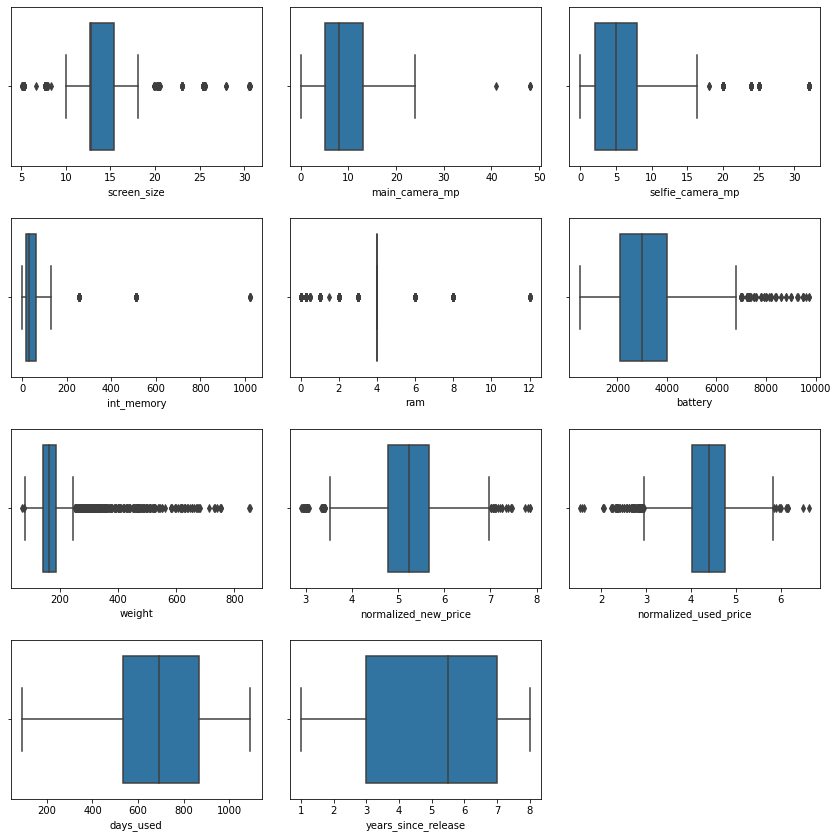

<IPython.core.display.Javascript object>

In [90]:
# Numerical variables
cols = X.select_dtypes(include='float').columns.tolist()[1:]
plt.figure(figsize=(12, 12))

for i, var in enumerate(cols):
  plt.subplot(4, 3, i + 1)
  sns.boxplot(data=X, x=var)
  plt.tight_layout(pad=2)

plt.subplot(4, 3, 9);
sns.boxplot(x=y);
plt.tight_layout(pad=2);

plt.subplot(4, 3, 10)
sns.boxplot(data=X, x='days_used');
plt.tight_layout(pad=2)

plt.subplot(4, 3, 11)
sns.boxplot(data=X, x='years_since_release');
plt.tight_layout(pad=2)

plt.show();

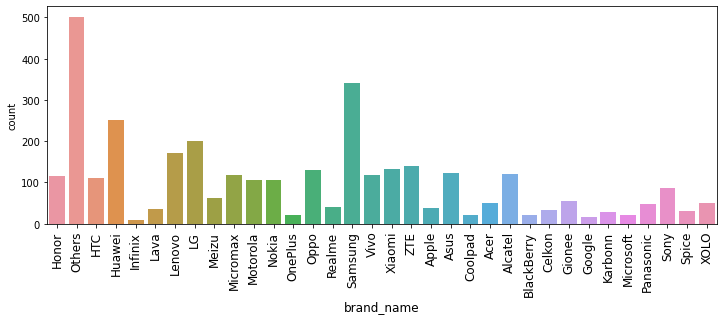

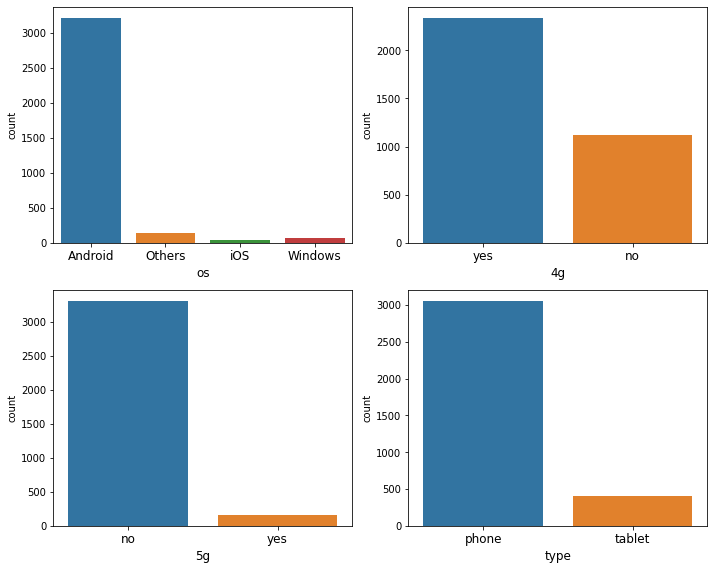

<IPython.core.display.Javascript object>

In [91]:
# Categorical variables
plt.figure(figsize=(12, 4))
sns.countplot(data=dfpp, x='brand_name');
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('brand_name', fontsize=12)
plt.show();

plt.figure(figsize=(10, 8))
for i, var in enumerate(dfpp.select_dtypes(include='object').columns[1:]):
  plt.subplot(2, 2, i + 1)
  sns.countplot(data=dfpp, x=var);
  plt.xticks(fontsize=12)
  plt.xlabel(var, fontsize=12)  
  plt.tight_layout(pad=1)

plt.show();

**Bivariate analysis**

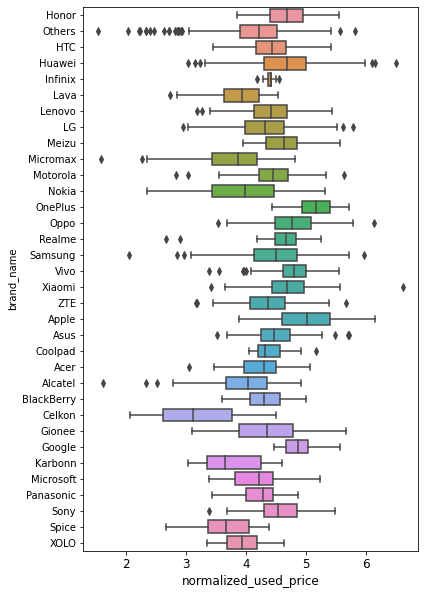

<IPython.core.display.Javascript object>

In [92]:
# Bivariate analysis
plt.figure(figsize=(6, 10))
sns.boxplot(data=dfpp, y='brand_name', x='normalized_used_price');
plt.xticks(fontsize=12)
plt.xlabel('normalized_used_price', fontsize=12)
plt.show();

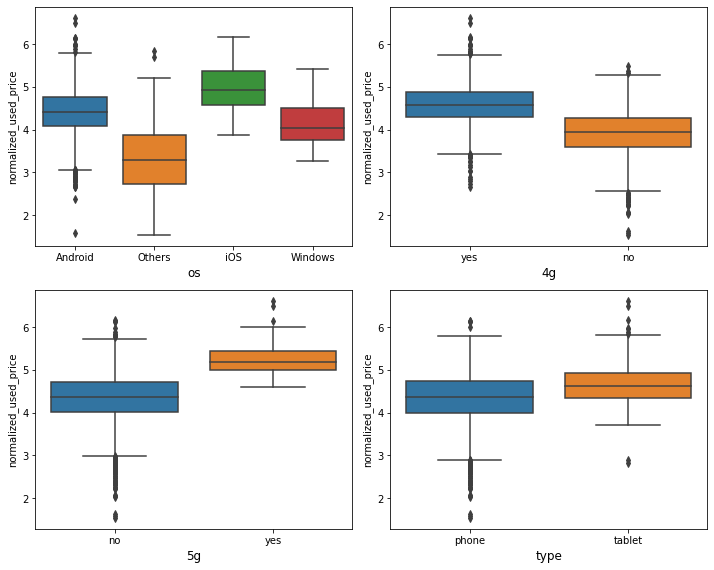

<IPython.core.display.Javascript object>

In [93]:
plt.figure(figsize=(10, 8))
for i, var in enumerate(dfpp.select_dtypes(include='object').columns[1:]):
  plt.subplot(2, 2, i + 1)
  sns.boxplot(data=dfpp, x=var, y='normalized_used_price');
  plt.xlabel(var, fontsize=12)
  plt.tight_layout(pad=1)

plt.show();

**Correlation heatmap**

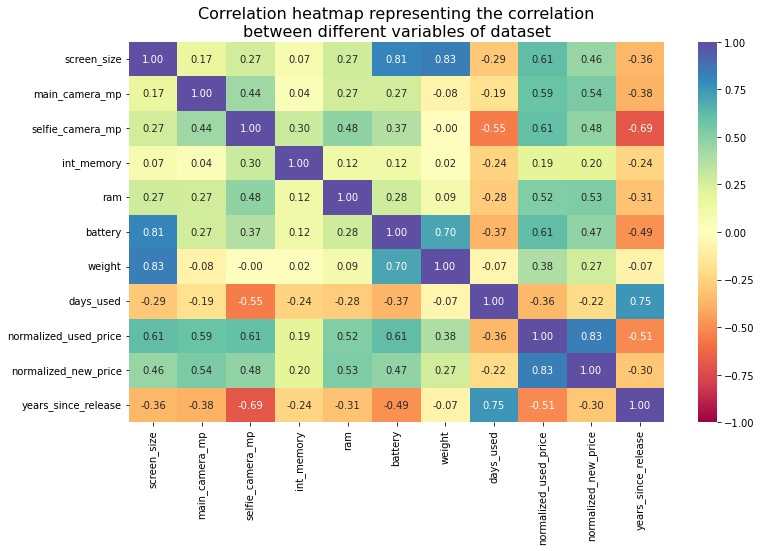

<IPython.core.display.Javascript object>

In [94]:
plt.figure(figsize=(12, 7))
sns.heatmap(dfpp.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation heatmap representing the correlation\nbetween different variables of dataset', fontsize=16)
plt.show();

**Pairplot**

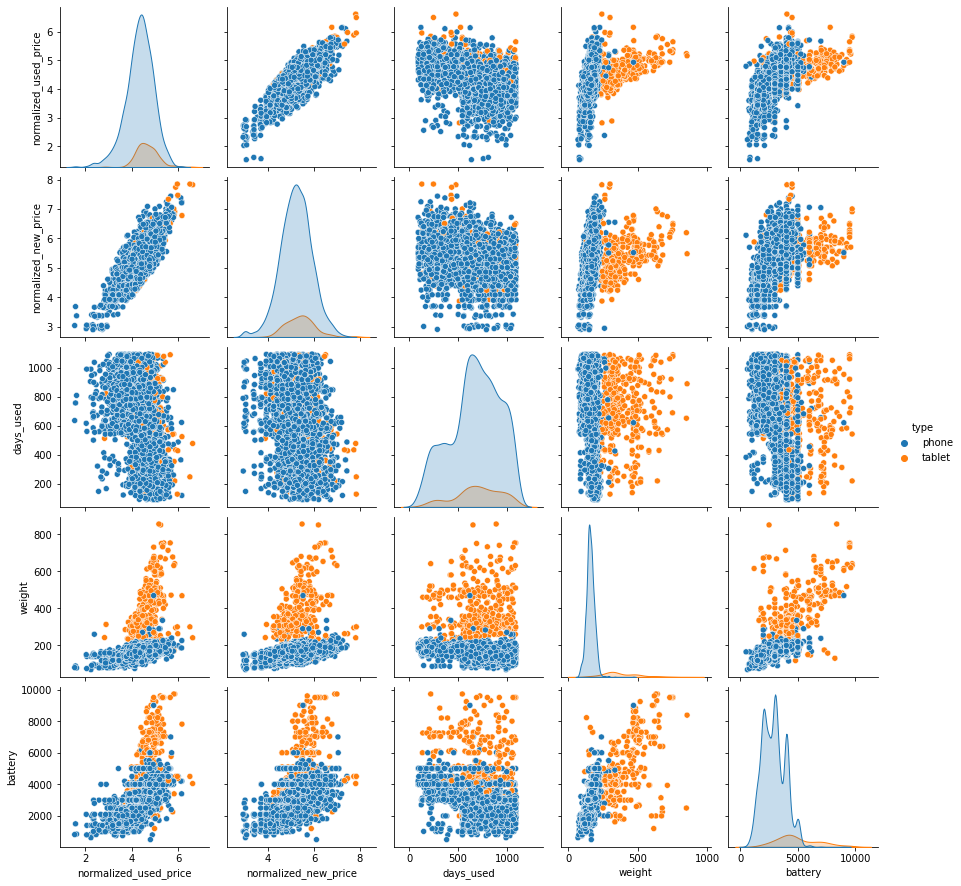

<IPython.core.display.Javascript object>

In [95]:
numeric = ['normalized_used_price', 'normalized_new_price', 'days_used', 'weight', 'battery', 'type']
sns.pairplot(dfpp[numeric], hue='type');

* On the pair plot, we can see different behavior of some variables by device type (phone/tablet). That might be essential for modeling
* **After manipulating, the data look consistent**

# Model Building - Linear Regression

In [96]:
oslmodel = sm.OLS(y_train, X_train).fit()
print(oslmodel.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.845
Model:                               OLS   Adj. R-squared:                  0.842
Method:                    Least Squares   F-statistic:                     263.2
Date:                   Fri, 24 Feb 2023   Prob (F-statistic):               0.00
Time:                           06:08:10   Log-Likelihood:                 124.19
No. Observations:                   2417   AIC:                            -148.4
Df Residuals:                       2367   BIC:                             141.1
Df Model:                             49                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>

### Interpreting the Regression Results:

1. **Adjusted R-squared**: It reflectsthe fit of the model.
  * Adjusted R-squared values generally range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.
  * In our case, the value for adj. R-squared is **0.842**, which is good.

2. ***`const`* coefficient**: It is the Y-intercept.
  * It means that if all the predictor variable coefficients are zero, then the expected output (i.e., Y) would be equal to the const coefficient.
  * In our case, the value for const coefficient is **1.3211**

3. **Coefficient of a predictor variable**: It represents the change in the output Y due to a change in the predictor variable (everything else held constant).
  * In our case, the coefficient of `screen_size` is **0.0238**.
  * We cannot interpret the coefficients of predictors until check linear regression assumptions, as for example, multicollinearity can cause problems when we interpret the model's results.

4. **$P>|t|$**
  * Some of the variables in the model have p-value > 0.05. So, they are not significant and we'll drop them on the next steps.

# Model Performance Check

Let's check the performance of the model using different metrics.

* We will be using metric functions defined in sklearn for RMSE, MAE, and $R^2$
* We will define a function to calculate MAPE and $R^2_{adj}$
  * The mean absolute percentage error (MAPE) measures the accuracy of predictions as a percentage, and can be calculated as the average absolute percent error for each predicted value minus actual values divided by actual values. It works best if there are no extreme values in the data and none of the actual values are 0.
  * We have created a function which print out all the above metrics in one go

In [97]:
# checking model performance on train set (seen 70% data)
print("Training Performance\n")
model_train_perf = model_performance_regression(oslmodel, X_train, y_train)
model_train_perf

Training Performance



RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.229852  0.180275   0.844929        0.841652  4.325608

<IPython.core.display.Javascript object>

In [98]:
# checking model performance on test set
print("Testing Performance\n")
model_test_perf = model_performance_regression(oslmodel, X_test, y_test)
model_test_perf

Testing Performance



RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.238438  0.184799   0.842374         0.83438  4.504304

<IPython.core.display.Javascript object>

**Observations**

* The training $R^2$ is **0.845**, so the model is not underfitting
* The train and test RMSE and MAE are comparable, so the model is not overfitting either
* MAE suggests that the model can predict normalized used device price within a mean error of **0.18** on the test data
* MAPE of 4.5 on the test data means that we are able to predict within **4.5\%** of the normalized used device price

# Checking Linear Regression Assumptions

* In order to make statistical inferences from a linear regression model, it is important to ensure that the assumptions of linear regression are satisfied.
* We will be checking the following Linear Regression assumptions:
  1. **No Multicollinearity**
  2. **Linearity of variables**
  3. **Independence of error terms**
  4. **Normality of error terms**
  5. **No Heteroscedasticity**


##**TEST FOR MULTICOLLINEARITY**

* Multicollinearity occurs when predictor variables in a regression model are correlated. This correlation is a problem because predictor variables should be independent. If the correlation between variables is high, it can cause problems when we fit the model and interpret the results. When we have multicollinearity in the linear model, the coefficients that the model suggests are unreliable.
* There are different ways of detecting (or testing) multicollinearity. One such way is by using the Variance Inflation Factor, or VIF.
* **Variance Inflation Factor (VIF)**: Variance inflation factors measure the inflation in the variances of the regression parameter estimates due to collinearities that exist among the predictors. It is a measure of how much the variance of the estimated regression coefficient $\beta_k$  is "inflated" by the existence of correlation among the predictor variables in the model.
  * If VIF is 1, then there is no correlation among the $k$th predictor and the remaining predictor variables, and hence, the variance of $\beta_k$ is not inflated at all.

* **General Rule of thumb**:
  * If VIF is between 1 and 5, then there is low multicollinearity.
  * If VIF is between 5 and 10, we say there is moderate multicollinearity.
  * If VIF is exceeding 10, it shows signs of high multicollinearity.

The function to check VIF was defined above

###**Variance Inflation Factor**

In [99]:
# Outputting the VIF value for top-10 of all the variables
checking_vif(X_train).sort_values(by='VIF', ascending=False).head(10)

feature         VIF
0                 const  242.768994
12     brand_name_Apple   13.125023
46               os_iOS   11.846791
1           screen_size    9.910225
34    brand_name_Others    9.735730
37   brand_name_Samsung    7.545436
7                weight    6.675499
21    brand_name_Huawei    5.986725
10  years_since_release    5.006897
24        brand_name_LG    4.863838

<IPython.core.display.Javascript object>

* There are multiple columns with very high VIF values, indicating presence  of strong multicollinearity
* We will systematically drop numerical columns with VIF > 5
* We will ignore the VIF values for dummy variables and the constant (intercept)

In [100]:
# Outputting the columns with VIF value is 5 and higher, except the dummy vars and the constant
vif = checking_vif(X_train)
vif = vif[~vif.feature.str.startswith(tuple(dummies+['const']))]
vif = vif[vif['VIF']>5]
print("VIF:")
vif.sort_values(by='VIF', ascending=False)

VIF:


feature       VIF
1           screen_size  9.910225
7                weight  6.675499
10  years_since_release  5.006897

<IPython.core.display.Javascript object>

* There are three variables with high VIF. We need to choose one of them to drop from the dataset

###**Removing Multicollinearity**

To remove multicollinearity
  1. Drop every column one by one that has a VIF score greater than 5.
  2. Look at the adjusted R-squared and RMSE of all these models.
  3. Drop the variable that makes the least change in adjusted R-squared.
  4. Check the VIF scores again.
  5. Continue till you get all VIF scores under 5.

We've defined a function that will help us do this.

In [101]:
# Columns with hight VIF
treat = treating_multicollinearity(X_train, y_train, vif.feature)
treat

col  R-squared  Adj. R-squared after_dropping col  \
0  years_since_release   0.843175                           0.839996   
1          screen_size   0.842443                           0.839249   
2               weight   0.841467                           0.838253   

   RMSE after dropping col  
0                 0.233527  
1                 0.234072  
2                 0.234796

<IPython.core.display.Javascript object>

* The `screen_size` and `years_since_release` make the least change in adjusted R-squared
* However, the `screen_size` has higher VIF
* We will drop the `screen_size` and check the VIF scores again.

### **Iteration #2**

In [102]:
# Drop `screen_size` from train and test
X_train2 = X_train.drop('screen_size', axis=1)
X_test2 = X_test.drop('screen_size', axis=1)

# Check VIF now
vif = checking_vif(X_train2)
vif = vif[~vif.feature.str.startswith(tuple(dummies+['const']))]
vif = vif[vif['VIF']>5]
print("VIF after dropping ", treat['col'][0])
vif.sort_values(by='VIF', ascending=False)



VIF after dropping  years_since_release


Empty DataFrame
Columns: [feature, VIF]
Index: []

<IPython.core.display.Javascript object>

* We have dealt with multicollinearityin the data
* Let's rebuild the model using yje updated set of predictors variables

In [103]:
olsmod2 = sm.OLS(y_train, X_train2).fit()
print(olsmod2.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.842
Model:                               OLS   Adj. R-squared:                  0.839
Method:                    Least Squares   F-statistic:                     263.8
Date:                   Fri, 24 Feb 2023   Prob (F-statistic):               0.00
Time:                           06:08:14   Log-Likelihood:                 104.97
No. Observations:                   2417   AIC:                            -111.9
Df Residuals:                       2368   BIC:                             171.8
Df Model:                             48                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>

**Interpreting the Regression Results:**
  1. **`std err`**: It reflects the level of accuracy of the coefficients.
    * The lower it is, the higher is the level of accuracy.

  2. $P>|t|$: It is p-value.
    * For each independent feature, there is a null hypothesis and an alternate hypothesis. Here $\beta_i$ is the coefficient of the $i$th independent variable.
      * $H_0$: Independent feature is not significant ($\beta_i=0$)
      * $H_a$: Independent feature is that it is significant ($\beta_i\neq0$)
    * $P>|t|$ gives the p-value for each independent feature to check that null hypothesis. We are considering 5% as significance level.
      * A p-value of less than 0.05 is considered to be statistically significant.
    
  3. **Confidence Interval**: It represents the range in which our coefficients are likely to fall (with a likelihood of 95%).

**Observations**

* We can see that $R^2_{adj}$ has dropped from **0.842** to **0.839**
  * That shows that the dropped column `screen_size` did not have much effect on the model
* As there is no multicollinearity, we can look at the p-values of predictor variables to check their significance

**Dealing with high p-value variables**

* Some of the dummy variables in the data have p-value > 0.05. So, they are not significant and we'll drop them
* But sometimes p-values change after dropping a variable. So, we'll not drop all variables at once
* Instead, we will do the following:
  * Build a model, check the p-values of the variables, and drop the column with the highest p-value
  * Create a new model without the dropped feature, check the p-values of the variables, and drop the column with the highest p-value
  * Repeat the above two steps till there are no columns with p-value > 0.05

**Note**: The above process can also be done manually by picking one variable at a time that has a high p-value, dropping it, and building a model again. But that might be a little tedious and using a loop will be more efficient.

In [104]:
# initial list of columns
predictors = X_train2.copy()
selected_features = predictors.columns.tolist()
max_p_value = 1

while len(selected_features) > 0:
    model = sm.OLS(y_train, predictors[selected_features]).fit()

    if max(model.pvalues) > 0.05:
        selected_features.remove(model.pvalues.idxmax())
        print(f'Column `{model.pvalues.idxmax()}` has been removed')
    else:
        break

print('\nSelected features are: ')
print(pd.Series(selected_features))

Column `brand_name_Huawei` has been removed
Column `brand_name_Vivo` has been removed
Column `brand_name_ZTE` has been removed
Column `os_Windows` has been removed
Column `brand_name_Spice` has been removed
Column `brand_name_Meizu` has been removed
Column `brand_name_BlackBerry` has been removed
Column `brand_name_Motorola` has been removed
Column `brand_name_HTC` has been removed
Column `brand_name_LG` has been removed
Column `brand_name_Others` has been removed
Column `brand_name_Celkon` has been removed
Column `brand_name_Google` has been removed
Column `brand_name_Micromax` has been removed
Column `brand_name_Coolpad` has been removed
Column `brand_name_Apple` has been removed
Column `brand_name_Asus` has been removed
Column `days_used` has been removed
Column `brand_name_XOLO` has been removed
Column `brand_name_Oppo` has been removed
Column `brand_name_Realme` has been removed
Column `battery` has been removed
Column `brand_name_Gionee` has been removed
Column `brand_name_Lava` 

<IPython.core.display.Javascript object>

### **Iteration #3**

In [105]:
X_train3 = X_train2[selected_features]
X_test3 = X_test2[selected_features]

<IPython.core.display.Javascript object>

In [106]:
olsmod3 = sm.OLS(y_train, X_train3).fit()
print(olsmod3.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.840
Model:                               OLS   Adj. R-squared:                  0.839
Method:                    Least Squares   F-statistic:                     842.4
Date:                   Fri, 24 Feb 2023   Prob (F-statistic):               0.00
Time:                           06:08:15   Log-Likelihood:                 88.791
No. Observations:                   2417   AIC:                            -145.6
Df Residuals:                       2401   BIC:                            -52.94
Df Model:                             15                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

<IPython.core.display.Javascript object>

In [107]:
# checking model performance on train set (seen 70% data)
print("Training Performance\n")
mod3_train_perf = model_performance_regression(olsmod3, X_train3, y_train)
mod3_train_perf

Training Performance



RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.233243  0.182023    0.84032        0.839255  4.375982

<IPython.core.display.Javascript object>

In [108]:
# checking model performance on test set (seen 30% data)
print("Test Performance\n")
mod3_test_perf = model_performance_regression(olsmod3, X_test3, y_test)
mod3_test_perf

Test Performance



RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.239841  0.184879   0.840512         0.83801  4.516599

<IPython.core.display.Javascript object>

###**Observations**


* Now no feature has p-value greater than 0.05, so we'll consider the features in `x_train3` as the final set of predictor variables and `olsmod3` as the final model to move forward with
* Now adjusted R-squared is **0.840**, i.e., our model is able to explain ~**84%** of the variance
* The adjusted R-squared in `olsmod2` (where we considered the variables without multicollinearity) was **0.842**
* This shows that the variable we dropped was not affecting the model
RMSE and MAE values are comparable for train and test sets, indicating that the model is not overfitting
* **There is no multicollinearity in the dataset**

**Now we'll check the rest of the assumptions on olsmod3**
1. Linearity of variables
2. Independence of error terms
3. Normality of error terms
4. No Heteroscedasticity


##**TEST FOR LINEARITY AND INDEPENDENCE**


**Why the test?**
* Linearity describes a straight-line relationship between two variables, predictor variables must have a linear relation with the dependent variable.
* The independence of the error terms (or residuals) is important. If the residuals are not independent, then the confidence intervals of the coefficient estimates will be narrower and make us incorrectly conclude a parameter to be statistically significant.

**How to check linearity and independence?**
* Make a plot of fitted values vs residuals.
* If they don't follow any pattern, then we say the model is linear and residuals are independent.
* Otherwise, the model is showing signs of non-linearity and residuals are not independent.

**How to fix if this assumption is not followed?**
* We can try to transform the variables and make the relationships linear.

###**Residuals**

In [109]:
# let us create a dataframe with actual, fitted and residual values
df_pred = pd.DataFrame()

df_pred["Actual Values"] = y_train  # actual values
df_pred["Fitted Values"] = olsmod3.fittedvalues  # predicted values
df_pred["Residuals"] = olsmod3.resid  # residuals

df_pred.head()

Actual Values  Fitted Values  Residuals
3026       4.087488       3.870447   0.217040
1525       4.448399       4.579927  -0.131527
1128       4.315353       4.284748   0.030605
3003       4.282068       4.197748   0.084320
2907       4.456438       4.492847  -0.036408

<IPython.core.display.Javascript object>

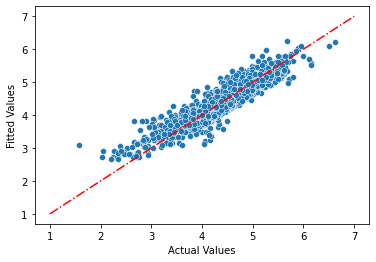

<IPython.core.display.Javascript object>

In [110]:
# let's draw a scatterplot to compare Actual values vs. Fitted Values
sns.scatterplot(x=df_pred['Actual Values'], y=df_pred['Fitted Values'])
sns.lineplot([1,7], [1,7], color='r', linestyle='dashdot');

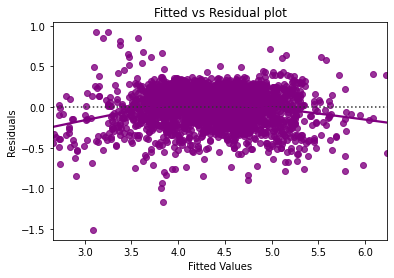

<IPython.core.display.Javascript object>

In [111]:
# let's plot the fitted values vs residuals

sns.residplot(data=df_pred, x="Fitted Values", y="Residuals", color="purple", lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residual plot")
plt.show();

###**Observations**

* The scatter plot shows the distribution of residuals (errors) vs fitted values (predicted values).
* If there exist any pattern in this plot, we consider it as signs of non-linearity in the data and a pattern means that the model doesn't capture non-linear effects.
* **We see no pattern in the plot above. Hence, the assumptions of linearity and independence are satisfied.**

## **TEST FOR NORMALITY**

**Why the test?**
* Error terms, or residuals, should be normally distributed. If the error terms are not normally distributed, confidence intervals of the coefficient estimates may become too wide or narrow. Once confidence interval becomes unstable, it leads to difficulty in estimating coefficients based on minimization of least squares. Non-normality suggests that there are a few unusual data points that must be studied closely to make a better model.

**How to check normality?**
* The shape of the histogram of residuals can give an initial idea about the normality.
* It can also be checked via a Q-Q plot of residuals. If the residuals follow a normal distribution, they will make a straight line plot, otherwise not.
* Other tests to check for normality includes the Shapiro-Wilk test.
  * Null hypothesis: Residuals are normally distributed
  * Alternate hypothesis: Residuals are not normally distributed

**How to fix if this assumption is not followed?**
* We can apply transformations like log, exponential, arcsinh, etc. as per our data.

###**Normality**

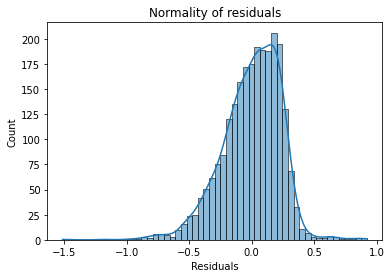

<IPython.core.display.Javascript object>

In [112]:
sns.histplot(data=df_pred, x="Residuals", kde=True)
plt.title("Normality of residuals")
plt.show();

* The histogram of residuals does have a bell shape, left skewed.
* Let's check the Q-Q plot.

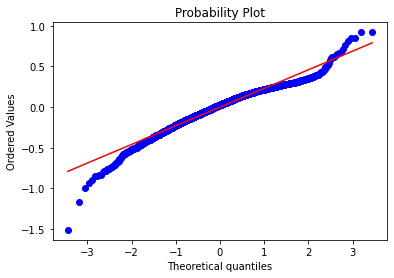

<IPython.core.display.Javascript object>

In [113]:
import pylab
import scipy.stats as stats

stats.probplot(df_pred["Residuals"], dist="norm", plot=pylab)
plt.show()

* The residuals more or less follow a straight line except for the tails
* Let's check the results of the Shapiro-Wilk test.

In [114]:
stats.shapiro(df_pred["Residuals"])

ShapiroResult(statistic=0.9675482511520386, pvalue=6.226413491682132e-23)

<IPython.core.display.Javascript object>

###**Observations**

* Since p-value < 0.05, the residuals are not normal as per the Shapiro-Wilk test.
* Strictly speaking, the residuals are not normal.
* However, as an approximation, we can accept this distribution as close to being normal.
* **So, the assumption is satisfied.**

##**TEST FOR HOMOSCEDASTICITY**

* **Homoscedascity**: If the variance of the residuals is symmetrically distributed across the regression line, then the data is said to be homoscedastic.
* **Heteroscedascity**: If the variance is unequal for the residuals across the regression line, then the data is said to be heteroscedastic.

**Why the test?**
* The presence of non-constant variance in the error terms results in heteroscedasticity. Generally, non-constant variance arises in presence of outliers.

**How to check for homoscedasticity?**
* The residual vs fitted values plot can be looked at to check for homoscedasticity. In the case of heteroscedasticity, the residuals can form an arrow shape or any other non-symmetrical shape.
* The goldfeldquandt test can also be used. If we get a p-value > 0.05 we can say that the residuals are homoscedastic. Otherwise, they are heteroscedastic.
  * Null hypothesis: Residuals are homoscedastic
  * Alternate hypothesis: Residuals have heteroscedasticity

**How to fix if this assumption is not followed?**
* Heteroscedasticity can be fixed by adding other important features or making transformations.

###**Homoscedascity**

In [115]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(df_pred["Residuals"], X_train3)
lzip(name, test)

[('F statistic', 1.0190491334733005), ('p-value', 0.3723058892893009)]

<IPython.core.display.Javascript object>

###**Observations**

* Since p-value > 0.05, we can say that the residuals are homoscedastic.
* **So, this assumption is satisfied.**

##**Predictions on test data**

Now that we have checked all the assumptions of linear regression and they are satisfied, let's go ahead with prediction.

In [116]:
# predictions on the test set
pred = olsmod3.predict(X_test3)

df_pred_test = pd.DataFrame({"Actual": y_test, "Predicted": pred})
df_pred_test['Diff'] = df_pred_test['Predicted']-df_pred_test['Actual']
df_pred_test['Diff, %'] = round(100*df_pred_test['Diff']/df_pred_test['Actual'],2)
df_pred_test.sample(10, random_state=42)

Actual  Predicted      Diff  Diff, %
2360  4.597541   4.728633  0.131092     2.85
1413  3.463546   3.774185  0.310639     8.97
1884  3.875359   4.049946  0.174587     4.51
1922  3.747620   3.732205 -0.015415    -0.41
396   4.170843   3.857928 -0.312914    -7.50
340   5.342526   5.322020 -0.020506    -0.38
1556  3.780547   3.577012 -0.203534    -5.38
2597  4.225227   4.103573 -0.121654    -2.88
2341  3.696103   3.998392  0.302289     8.18
1768  3.479700   3.714218  0.234518     6.74

<IPython.core.display.Javascript object>

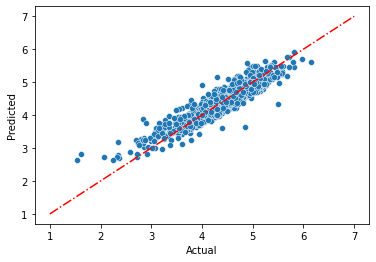

<IPython.core.display.Javascript object>

In [117]:
# let's draw a scatterplot to compare Actual values vs. Predicted Values
sns.scatterplot(x=df_pred_test['Actual'], y=df_pred_test['Predicted'])
sns.lineplot([1,7], [1,7], color='r', linestyle='dashdot');

* We can observe here that our model has returned pretty good prediction results, and the actual and predicted values are comparable

# Final Model

In [118]:
X_train_final = X_train3.copy()
X_test_final = X_test3.copy()

<IPython.core.display.Javascript object>

In [119]:
model_final = sm.OLS(y_train, X_train_final).fit()
print(model_final.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.840
Model:                               OLS   Adj. R-squared:                  0.839
Method:                    Least Squares   F-statistic:                     842.4
Date:                   Fri, 24 Feb 2023   Prob (F-statistic):               0.00
Time:                           06:08:18   Log-Likelihood:                 88.791
No. Observations:                   2417   AIC:                            -145.6
Df Residuals:                       2401   BIC:                            -52.94
Df Model:                             15                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

<IPython.core.display.Javascript object>

In [120]:
# checking model performance on train set (seen 70% data)
print("Training Performance\n")
model_final_train_perf = model_performance_regression(model_final, X_train_final, y_train)
model_final_train_perf

Training Performance



RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.233243  0.182023    0.84032        0.839255  4.375982

<IPython.core.display.Javascript object>

In [121]:
# checking model performance on test set (seen 30% data)
print("Test Performance\n")
model_final_test_perf = model_performance_regression(model_final, X_test_final, y_test)
model_final_test_perf

Test Performance



RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.239841  0.184879   0.840512         0.83801  4.516599

<IPython.core.display.Javascript object>

**Observations**

* The model is able to explain ~**84%** of the variation in the data
* The train and test RMSE and MAE are low and comparable. So, our model is not suffering from overfitting
* The MAPE on the test set suggests we can predict within **4.5%** of the normalized price of used devices
* **Hence, we can conclude the model `olsmodel_final` is good for prediction as well as inference purposes**

# Actionable Insights and Recommendations 

1. The model is able to explain ~84% of the variation in the data and within 4.5% of the normalized price of used devices on the test data, which is good. This indicates that the model is good for prediction as well as inference purposes.
2. The most significant predictors of the used device normalized price are the normalized price of a new device of the same model, the weight of the device, 4g and 5g availability, os, brand, the resolution of the main and selfie cameras, release year , the amount of RAM, and the type of device (tablet or phone).
3. If resolution of the `main_camera_mp` of an used device increases by one unit (MP), then its normalized price increases by 0.0221 units, all other variables held constant.
4. If resolution of the `selfie_camera_mp` of an used device increases by one unit (MP), then its normalized price increases by 0.0142 units, all other variables held constant.
5. If the `ram` of an used device increases by one unit (GB), then its normalized price increases by 0.0223 units, all other variables held constant.
6. If the `weight` of an used device increases by one unit (g), then its normalized price increases by 0.0014 units, all other variables held constant.
7. If the `normalized_new_price` of an used device increases by one unit, then its normalized price increases by 0.4413 units, all other variables held constant.
8. If the `years_since_release` of an used device increases by one unit (year), then its normalized price decreases by 0.0294 units, all other variables held constant.
10. The normalized price of used device with 4g support will be 0.0497 units higher than device without 4g, all other variables held constant.
11. The normalized price of used device with 5g support will be 0.0726 units less than device without 5g, all other variables held constant$^1$.
12. The normalized price of used tablet will be 0.1060 units higher than used phone, all other variables held constant.
13. The normalized price of used device runs on iOS will be 0.0915 units less than device runs on Android, all other vars held constant$^1$.
14. The normalized price of used device runs on 'Others' OS will be 0.1238 units less than device runs on Android, all other vars held const$^1$.
15. Brands. The normalized price of used device of the following brands will be (all other variables held constant):
  * Karbonn: 0.1118 units higher than device manufactured by Acer, 
  * Samsung: 0.0404 units less than device manufactured by Acer, 
  * Sony: 0.0697 units less than device manufactured by Acer, 
  * Xiaomi: 0.0801 units higher than device manufactured by Acer.

$^1$ *iOS devices, as well as devices with 5G, cost more than others on average. That might cause a question about the negative coefficient of the regression for these variables.*

*Indeed, for these devices (`iOS`, `Others` os; `5G`) prices are higher than for others, but the discounts for these devices are also higher - see sub-section 'Additional analysis' in the EDA section above. So, if a device works on `iOS`/`Others` or supports 5G, its `normalized_used_price` will be less than the price of the device that works on `Android` (or without `5G`) if all other variables are held constant.*

**Business recommendations**

* Since, ReCell wants us to predict the price of a used phone/tablet and identify factors that significantly influence it, they need to focus on phones and tablets released after 2019 and have main and selfie cameras' resolutions above average.

* Weight, 4g, 5g, brand, and amount of RAM also influence the price of used devices.

* It might be helpful to perform a customer segmentation analysis to gain better insights into customers' preferences and develop sales and marketing programs based on these insights.

* ReCell can suggest phone/tablet repair service, sales of accessories and related products, trade-in options to attract more customers, and increases in the top and bottom lines.

* ReCell can work on developing different options like rent or lease devices.

___

In [122]:
#%%shell

#jupyter nbconvert --to html /content/project_3_at.ipynb

<IPython.core.display.Javascript object>